# Makemore 3

[Video](https://www.youtube.com/watch?v=P6sfmUTpUmc)<br>
[Repository](https://github.com/karpathy/makemore)

(Notebook by [mk2112](https://github.com/mk2112))

## Table of Contents

- [Goals and Intentions](#goals-and-intentions)
- [Setting up the Dataset](#setting-up-the-dataset)
- [Problem 1: Unrealistically High Initial Loss](#problem-1-unrealistically-high-initial-loss)
- [Problem 2: Frequent Tanh Extrema](#problem-2-frequent-tanh-extrema)
  - [Why does hpreact indicate a problem?](#why-does-hpreact-indicate-a-problem)
- [Problem 1+2: Weight- und Bias-Skalierung](#problem-12-weight--und-bias-skalierung)
- [Batch Normalization](#batch-normalization)
  - [The Cost of Batch-Normalization](#the-cost-of-batch-normalization)
- [Digression: Convolutional Layers](#digression-convolutional-layers)
- [Linear Layers in PyTorch](#linear-layers-in-pytorch)
- [Batch-Normalization in PyTorch](#batch-normalization-in-pytorch)
- [Rebuilding the example in PyTorch](#rebuilding-the-example-in-pytorch)
  - [Activation Distribution for MLP with Tanh and Correct Gain](#activation-distribution-for-mlp-with-tanh-and-correct-gain)
  - [Activation Distribution for MLP with Tanh and Too Small Gain](#activation-distribution-for-mlp-with-tanh-and-too-small-gain)
  - [Gradient Distribution for MLP with Tanh and Correct Gain](#gradient-distribution-for-mlp-with-tanh-and-correct-gain)
  - [Gradient Distribution for MLP with Tanh and Too Small Gain](#gradient-distribution-for-mlp-with-tanh-and-too-small-gain)
  - [Activation Distribution and Gradient Distribution for MLP without Tanh and Too Small Gain](#activation-distribution-and-gradient-distribution-for-mlp-without-tanh-and-too-small-gain)
  - [Activation Distribution and Gradient Distribution for MLP with Tanh and Correct Gain](#activation-distribution-and-gradient-distribution-for-mlp-with-tanh-and-correct-gain)
  - [Activation Distribution and Gradient Distribution for MLP with Tanh and Batch-Norm and Turned Off Gain](#activation-distribution-and-gradient-distribution-for-mlp-with-tanh-and-batch-norm-and-turned-off-gain)
- [Bonus Content (Not Covered in Lecture)](#bonus-content-not-covered-in-lecture)

## Goals and Intentions

With our last iteration, we moved our idea of a bigram model from a look-up table based approach to an MLP.<br>
This introduced, at first, the same performance, but also more flexibility. Through hyperparameter tuning, we beat the performance of the look-up table model significantly.

Let's stick with the MLP and specifically, how gradients flow, what they look like and how it all may go wrong.

**Goals:**
- Intro to Batch-Normalization and its role in stabilizing the training of deep NNs
- PyTorch-ifying and modularizing our NN code
- Intro to diagnostics, diagnostic tools and interpreting their values

**Explicitly NOT goals:**
- Performance optimization of the NN<br>(we just have the bottleneck of the context length and that stays as long as before)
- In-depth explanations of backward passes (the relationships that make the diagnostics meaningful) (this will follow in the next lecture)

We are already reach the current state of research with this lecture. The question of optimal initialization or backpropagation has simply not been solved yet. This is still a very active research area.

This lecture gives us tools to track whether we are at least on the right track with our settings or not.

Spoiler:<br>
The interaction between activations and gradients in the learning process of an MLP is a weakness because it does not optimize the model as well as possible.<br>
Subsequent RNNs, [GRUs](https://d2l.ai/chapter_recurrent-modern/gru.html), [Transformer](https://arxiv.org/abs/1706.03762) etc. have addressed this weakness more and more.

## Setting up the Dataset

In [1]:
# Imports are just like before
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

This code is just copied over from the previous notebook. Note that we immediately split the dataset into train, validation and test set now.

In [2]:
words = open('names.txt', 'r').read().splitlines() # read in all the words
print(words[:8])           # Show the first eight words
print(len(words), 'words') # Total amount of words in our dataset

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
32033 words


In [3]:
# Build a vocabulary of characters map them to integers
chars = sorted(list(set(''.join(words))))  # set(): Throwing out letter duplicates

stoi = {s:i+1 for i,s in enumerate(chars)} # Make tupels of type (char, counter)
stoi['.'] = 0                              # Add this special symbol's entry explicitly
itos = {i:s for s,i in stoi.items()}       # Switch order of (char, counter) to (counter, char)

vocab_size = len(itos)

# Showing the two mappings, they really just are mirrors of one another
print(itos)
print(stoi)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
27


In [4]:
# Build the dataset
block_size = 3 # Context length: How many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # Crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)

  print(X.shape, Y.shape)
  return X, Y

# Randomize the dataset (with reproducibility)
import random
random.seed(42)
random.shuffle(words)

# These are the "markers" we will use to divide the dataset
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

# Dividing the dataset into train, dev and test splits
Xtr, Ytr = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2]) # 10%
Xte, Yte = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


Just like before, we setup the MLP. Same size, same properties.<br>
The only difference is that hard-coded numbers are now variables.

In [5]:
n_embd = 10    # dimensionality of the character embedding vectors
n_hidden = 200 # number of neurons in the hidden layer of the MLP

g  = torch.Generator().manual_seed(2147483647)                 # For reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g) # 27 letters x 10 values inp layer
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) # 10 values x 3 priors x 200 neur.
b1 = torch.randn(n_hidden,                        generator=g) # 200 biases for the 200 neurons
W2 = torch.randn((n_hidden, vocab_size),          generator=g) # 200 inputs x 27 output neurons
b2 = torch.randn(vocab_size,                      generator=g) # 27 output biases

parameters = [C, W1, b1, W2, b2] # Cluster all parameters into one structure
print(sum(p.nelement() for p in parameters), 'parameters') # total parameters (3481 before)

for p in parameters:
    p.requires_grad = True

11897 parameters


The optimization is the exact same thing also. Cleaned up a bit, but the same.

In [6]:

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # mini-batch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # X,Y of this batch
    
    # Forward-Pass
    emb = C[Xb]                         # Embedding characters into vectors
    embcat = emb.view(emb.shape[0], -1) # Concatenate the vectors
    hpreact = embcat @ W1 + b1          # Hidden layer pre-activation
    h = torch.tanh(hpreact)             # Hidden layer
    logits = h @ W2 + b2                # Output layer
    loss = F.cross_entropy(logits, Yb)  # Loss function
    
    # Backward-Pass
    for p in parameters:
        p.grad = None # Making sure that prior iteration's gradients are gone
    loss.backward()   # This calculates the current (new) gradients
    
    # Update
    lr = 0.1 if i < (max_steps / 2) else 0.01 # Learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # Printing track stats every once in a while
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    
    # Adding current loss value to historic losses set (for later display)
    lossi.append(loss.log10().item())

      0/ 200000: 27.8817
  10000/ 200000: 2.8763
  20000/ 200000: 2.5827
  30000/ 200000: 2.8014
  40000/ 200000: 2.0292
  50000/ 200000: 2.5621
  60000/ 200000: 2.4700
  70000/ 200000: 2.1287
  80000/ 200000: 2.3536
  90000/ 200000: 2.2331
 100000/ 200000: 2.1253
 110000/ 200000: 2.4425
 120000/ 200000: 1.8558
 130000/ 200000: 2.4267
 140000/ 200000: 2.2195
 150000/ 200000: 2.1145
 160000/ 200000: 2.0836
 170000/ 200000: 1.7707
 180000/ 200000: 2.0925
 190000/ 200000: 1.8794


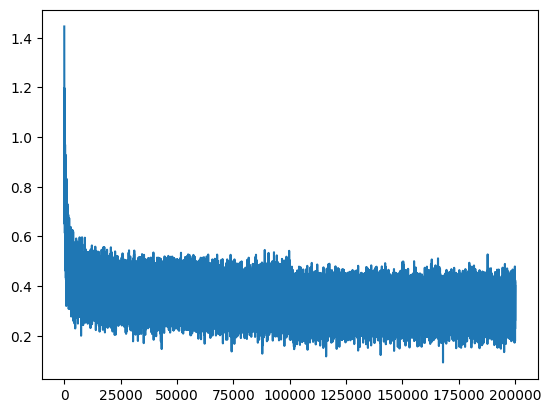

In [7]:
plt.plot(lossi)

Again, last time we had already evaluated the loss of the model for training and validation set.<br>
That's exactly what we do here again, but a bit more cleanly, neatly packaged into a function:

In [8]:
# See Makemore #2. We did this before but it's refactored here for convenience:
@torch.no_grad() # Decorator, disables gradient tracking (no "book-keeping" on torch's side)
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]    # That's a switch (never seen it like this!)
    
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # Concatenate into (N, block_size * n_embd)
    
    h = torch.tanh(embcat @ W1 + b1)    # (N, n_hidden)
    logits = h @ W2 + b2                # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1261446475982666
val 2.1701879501342773


And just like before, we sample from the trained model:

In [9]:
# Sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # Forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      # Sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # Shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # As soon as we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # Decode and print the generated word

mora.
mayah.
seel.
nah.
yam.
renyre.
ejd.
leg.
adelyn.
elin.
shi.
jen.
eden.
estanara.
mykith.
karin.
shubergihamies.
kendreelynn.
nochorius.
macd.


This model is much better than the initial, look-up-based Bigram model. We can make this even better.<br>Let's further optimize the previous code by individually tackling the problems we still have with it.

## Problem 1: Unrealistically High Initial Loss

First of all, there is something wrong with the network's initialization.<br>
The `loss` is way too high. It quickly drops significantly, but why should we start training "expensively" like that?

> In the training of neural nets, it is almost always the case that you will have a rough idea of what loss you can expect at initialization.<br>
> That depends on the loss function and the problem setup.

The following is what we actually expect for the `loss` at initialization:<br>
One of $27$ characters could be the next character. At initialization, we randomly choose a next character with the model, without any learning experience.
That means that the chance of choosing the correct character is equally likely compared to the chance of choosing any other character. So, it's $\frac{1}{27}$

Transfered to the negative log likelihood, as we calculate this as loss of the model, we get $-\log(\frac{1}{27}) = \log(27) \approx 3.3$:

In [10]:
-torch.tensor(1/27.0).log()

tensor(3.2958)

We expect this $3.3$ as the initial loss.

**Why is this not the case?**<br>The NN currently creates probability distributions and it does so very randomly.<br>It has no idea of the concept that all $27$ outputs are equally likely to begin with.<br>So currently, individual letters are sometimes significantly more likely than others, driving the loss way up.

> Currently the NN is randomly but really confidently wrong. This results in really high initial loss.

This is another example of the same problem:

In [11]:
# 4-dimensional example of this issue (instead of 27-dimensional)
logits = torch.tensor([-8.0, 5.0, 1.0, 10.0]) # "Outputs" of an MLP
probs = torch.softmax(logits, dim=0)          # Turn logits into a normalized probability distribution
loss = -probs[2].log()                        # Loss of the label for this situation is 2

probs, loss

(tensor([1.5126e-08, 6.6920e-03, 1.2257e-04, 9.9319e-01]), tensor(9.0068))

Because the logits can take on (or are allowed to take on) such different values, it is unlikely for the NN to quickly learn a good combination of logits that reduces the loss.

**We want the logits to be around 0 when we initialize the NN.**<br>(Theoretically, the logits could also be chosen around any number, but by default, we do this with 0 as the center, so that we initialize closely to the range of the normal distribution)<br><br>**So the question is: How do we get the logits of the output layer to be initially close to 0?**

**Solution:** We scale $W2$ to be close to $0$ and turn off $b2$ by setting it $0$.

In [12]:
n_embd = 10
n_hidden = 200

g  = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # Small, but not 0
b2 = torch.randn(vocab_size,                      generator=g) * 0 # Initialize to 0

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

Ok, now the initialization of the output layer is compressed into a range very close to $0$, and for b2, all values are in fact initialized with $0$.<br>
This effectively removes the high variance of the logits and the very false initial distribution of the probabilities.<br>
How does this affect the NN performance now?

In [13]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # X,Y of this batch
    
    # Forward-Pass
    emb = C[Xb]                         
    embcat = emb.view(emb.shape[0], -1) 
    hpreact = embcat @ W1 + b1          
    h = torch.tanh(hpreact)             
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    # Backward-Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    lr = 0.1 if i < (max_steps / 2) else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Printing track stats every once in a while
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    
    # Adding current loss value to historic losses set (for later display)
    lossi.append(loss.log10().item())

      0/ 200000: 3.3221
  10000/ 200000: 2.1900
  20000/ 200000: 2.4196
  30000/ 200000: 2.6067
  40000/ 200000: 2.0601
  50000/ 200000: 2.4988
  60000/ 200000: 2.3903
  70000/ 200000: 2.1344
  80000/ 200000: 2.3369
  90000/ 200000: 2.1299
 100000/ 200000: 1.8329
 110000/ 200000: 2.2053
 120000/ 200000: 1.8540
 130000/ 200000: 2.4566
 140000/ 200000: 2.1879
 150000/ 200000: 2.1118
 160000/ 200000: 1.8956
 170000/ 200000: 1.8644
 180000/ 200000: 2.0326
 190000/ 200000: 1.8417


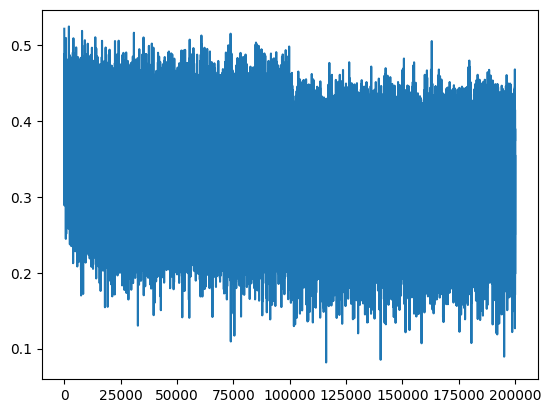

In [14]:
plt.plot(lossi)

In [15]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    
    emb = C[x]                          # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # Concatenate into (N, block_size * n_embd)
    
    h = torch.tanh(embcat @ W1 + b1)    # (N, n_hidden)
    logits = h @ W2 + b2                # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.069589138031006
val 2.131074905395508


The loss curve no longer looks like a hockey stick. Logically, we no longer have this high initial loss.

> Now that this hockeystick-problem is taken care of, the training process spends more time on actually optimizing rather than squashing unrealistic logits.

So the two good things are:
1. The loss looks like we expect it in the problem context
2. The loss curve during training looks more even.
3. Training and validation loss have dropped a bit.

Curiously enough, we set $b2$ to $0$ in a heartbeat and avoided doing the same for $W2$. Why?<br>
- We want to keep randomness in the weights, therefore they have to have some sort of value
- Weights with a value of $0$ cause the gradients to be none while a bias is solely added on top; weights with $0$ value thus are not good for the training process

## Problem 2: Frequent Tanh Extrema

Apart from **Problem 1**, there is a deeper problem within the NN.<br> The logits/outputs are now ok, but `h`, the vector of activations of the hidden layer, isn't.

`tanh` compresses arbitrary values into the range $[-1; 1]$.<br>Let's take a look at `h`:

In [16]:
print(h.shape)
print(h.view(-1).shape)

torch.Size([32, 200])
torch.Size([6400])


tensor([[ 0.7100, -0.7879, -0.7424,  ..., -1.0000,  1.0000,  1.0000],
        [-0.5613, -1.0000, -1.0000,  ..., -0.8078,  0.9971, -0.9209],
        [-1.0000,  0.9940, -1.0000,  ...,  0.3851, -0.9303,  0.3262],
        ...,
        [-0.9992, -1.0000, -0.9999,  ..., -0.4351, -0.8976, -0.3768],
        [ 0.9939,  0.8976,  1.0000,  ..., -0.9538, -1.0000,  0.9987],
        [-1.0000, -0.9995, -1.0000,  ..., -0.6407, -0.8208,  0.5100]],
       grad_fn=<TanhBackward0>) 



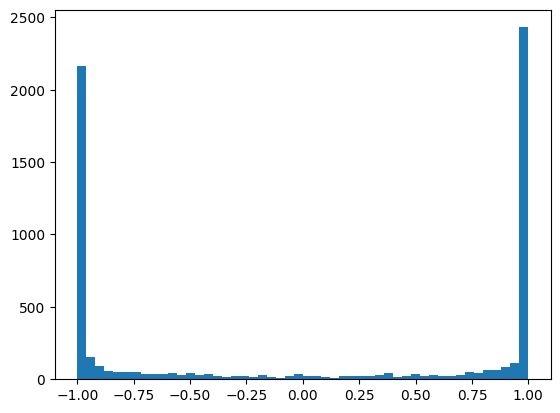

In [17]:
print(h, "\n") # hidden layer activations (32 x 200)
plt.hist(h.view(-1).tolist(), 50); # (6400 x 1), convert tensor to list, show histogram on distribution for 50 bins

One can see that a vast majority of the values are the `tanh` extrema.<br>**Why is that?**<br>We need to backtrack `h` here. `h` is based on `hpreact`, what's up with `hpreact`?

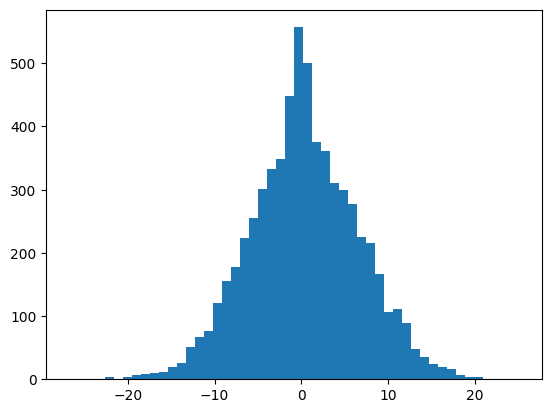

In [18]:
plt.hist(hpreact.view(-1).tolist(), 50);

We see that the values within `hpreact` are within a range of roughly $[-23; 21]$.<br>
`tanh` has to compress all of this into the range $[-1; 1]$.

### Why does hpreact indicate a problem?

The above scenario, `hpreact` having a narrow distribution, comes back to bite us during backpropagation.<br>
When backpropagating, we go through the operations and values of the MLP 'backwards'. We also do this with the `tanh` function that forms `h`.<br>
In our MLP, `tanh` is calculated for a total of $200$ activations.<br>

The derivative of `tanh` is $1 - t^2$.<br>
In combination with the chain rule, this is the gradient of `tanh`:

```python
self.grad += (1 - t**2) * out.grad
```

So what happens if the outputs `t` of our `tanh`, which we store in `h`, are $-1$ or $1$?<br>
Yep. That's a problem. The gradient becomes $0$.

> No matter the gradient, if the `tanh` results had been $-1$ or $1$, backpropagation through `tanh` will squash the gradients harshly, thereby extemely reducing gradient-learning effectiveness. **The gradient becomes $0$, killing any learning progress.**

Because `tanh` is so often so extreme, we only learn extremely slowly in the hidden layer or often nothing at all, because the gradients backpropagate to $0$ so often.

We can display how often the expected learning effect is suppressed by an extreme `tanh` value (and thereby gradient of $0$) with the following code:

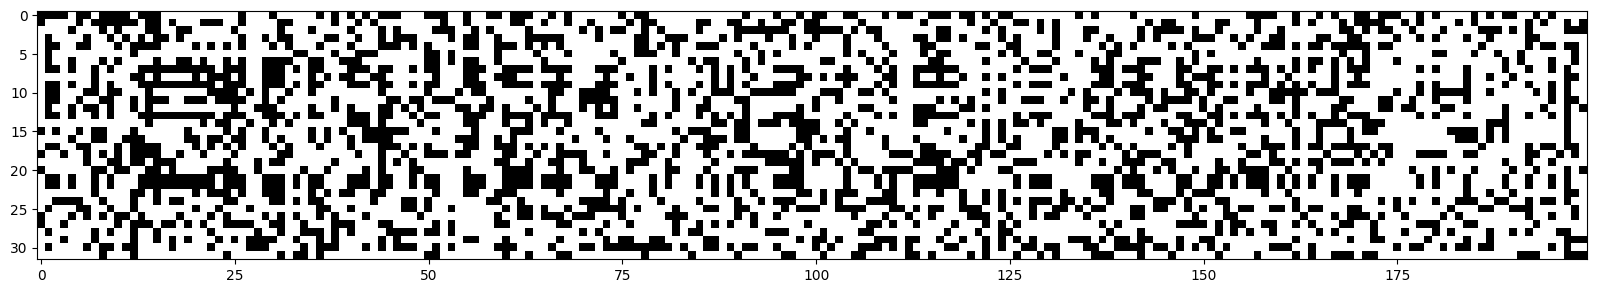

In [19]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest') # true: white, false: black (h is 32 x 200)

> If there was a column that was completely white, the respresented neuron would **never** learn. It would be a "dead neuron". 

Fortunately, we don't see that here, even though we come close in some cases.<br>
The same 'gradient crushing phenomenon' can be observed not only with `tanh`, but also with `sigmoid`, `ReLU` and `ELU`, meaning every activation function that flattens out at some point.<br>
(The flatter the function, the smaller the derivative (rate of change), the smaller the gradient, the less learning effect)

![](https://miro.medium.com/max/1200/1*ZafDv3VUm60Eh10OeJu1vw.png)

> Dead neurons can occur through initialization or through extremely boundary-distributed `tanh`, making learning for the affected neurons very very hard. It's like brain damage.

In short: We need to solve the `tanh` gradient squashing problem **urgently**!

We've seen with the unrealistically high initial loss that we can calm (at least initial) distributions by scaling the weights and biases.<br>
As the above diagram shows the problem to be prevalent in the hidden layer, we could now try to also compress `W1` and `b1` into a range that is near $0$.<br>
The `hpreact` input into `tanh` would then be more levelled.<br>
`tanh` would no longer tend towards extremes.<br>
That's worth a try!

In [20]:
n_embd = 10
n_hidden = 200

g  = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2  # Small, but not 0
b1 = torch.randn(n_hidden,                        generator=g) * 0.01 # Small, but not 0 bias
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # Small, but not 0
b2 = torch.randn(vocab_size,                      generator=g) * 0    # Biases are now all 0

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

We go and train the model again, but for just one batch:

In [21]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # X,Y of this batch
    
    # Forward-Pass
    emb = C[Xb]                         
    embcat = emb.view(emb.shape[0], -1) 
    hpreact = embcat @ W1 + b1          
    h = torch.tanh(hpreact)             
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    # Backward-Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    lr = 0.1 if i < (max_steps / 2) else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Printing track stats every once in a while
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    
    # Adding current loss value to historic losses set (for later display)
    lossi.append(loss.log10().item())
    
    break # run only the first batch

      0/ 200000: 3.3135


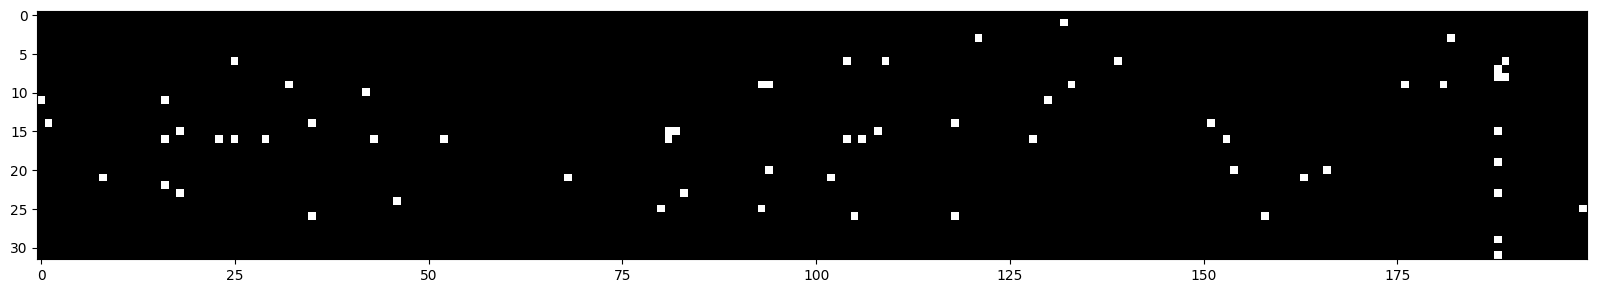

In [22]:
# We actually allow some to reach extremes, but its now rarely the case
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99 , cmap='gray', interpolation='nearest') # true: white, false: black

This looks much better! The distribution of `h` is now much more levelled, extremes are still within reach, but they are reached much less often.<br>
Next, let's look at the distribution of `h`:

tensor([[ 0.5503, -0.1064, -0.6658,  ..., -0.3477, -0.9756,  0.8880],
        [-0.9081, -0.1924, -0.1833,  ...,  0.0494,  0.4942,  0.4397],
        [ 0.8016,  0.1173,  0.8237,  ...,  0.2890,  0.6476,  0.8827],
        ...,
        [-0.9190,  0.5208, -0.0346,  ..., -0.0830,  0.8660,  0.8849],
        [-0.9362,  0.0930, -0.2810,  ..., -0.1260,  0.7874,  0.9102],
        [-0.9190,  0.5208, -0.0346,  ..., -0.0830,  0.8660,  0.8849]],
       grad_fn=<TanhBackward0>) 



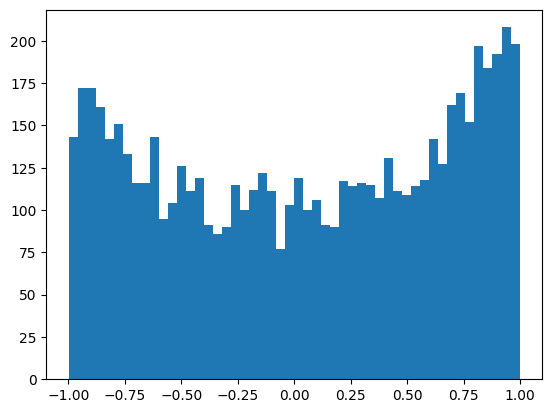

In [23]:
print(h, "\n")
plt.hist(h.view(-1).tolist(), 50);

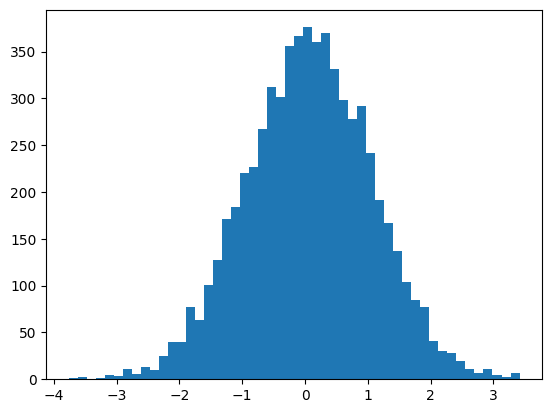

In [24]:
plt.hist(hpreact.view(-1).tolist(), 50);

Ok. With that out of the way, let's go ahead and fully train the model:

In [25]:
n_embd = 10
n_hidden = 200

g  = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # Small, but not 0
b2 = torch.randn(vocab_size,                      generator=g) * 0    # Biases are now all 0

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [26]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # X,Y of this batch
    
    # Forward-Pass
    emb = C[Xb]                         
    embcat = emb.view(emb.shape[0], -1) 
    hpreact = embcat @ W1 + b1          
    h = torch.tanh(hpreact)             
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    # Backward-Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    lr = 0.1 if i < (max_steps / 2) else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Printing track stats every once in a while
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    
    # Adding current loss value to historic losses set (for later display)
    lossi.append(loss.log10().item())

      0/ 200000: 3.3135
  10000/ 200000: 2.1648
  20000/ 200000: 2.3061
  30000/ 200000: 2.4541
  40000/ 200000: 1.9787
  50000/ 200000: 2.2930
  60000/ 200000: 2.4232
  70000/ 200000: 2.0680
  80000/ 200000: 2.3095
  90000/ 200000: 2.1207
 100000/ 200000: 1.8269
 110000/ 200000: 2.2045
 120000/ 200000: 1.9797
 130000/ 200000: 2.3946
 140000/ 200000: 2.1000
 150000/ 200000: 2.1948
 160000/ 200000: 1.8619
 170000/ 200000: 1.7809
 180000/ 200000: 1.9673
 190000/ 200000: 1.8295


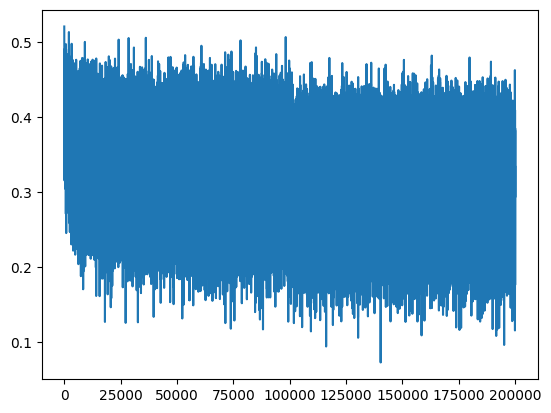

In [27]:
plt.plot(lossi)

In [28]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    
    emb = C[x]                          # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # Concatenate into (N, block_size * n_embd)
    
    h = torch.tanh(embcat @ W1 + b1)    # (N, n_hidden)
    logits = h @ W2 + b2                # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0355966091156006
val 2.102677822113037


These are the losses we've seen up until now:

| Losses | Original           | Solved Problem 1   | Solved Problem 2       |
| ------ | ------------------ | ------------------ | ---------------------- |
| train  | 2.1255977153778076 | 2.069535732269287  | **2.0355823040008545** |
| val    | 2.168022394180298  | 2.1311967372894287 | **2.1026716232299805** | 

<br>

>We've made progress!<br>
>With the solved problems, we made our training much more focused and more productive.

## Problem 1+2: Weight- und Bias-Skalierung

Our previous optimization was still relatively manageable for our example MLP. We only have a very flat MLP to work with here.<br>
The larger the MLP, the more difficult optimization becomes.

Well ... we now have a lot of "magic numbers", the factors for the weights and biases:

```
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0
```

**How do you determine and set these values for large multilayer MLPs?**

For the sake of illustration, let's assume we use one layer with both uniformly distributed weights and inputs.<br>
There is no activation function applied and neither is a bias added.

X: tensor(-0.0045) tensor(1.0041)
W: tensor(-0.0013) tensor(0.9949)
Y: tensor(0.0029) tensor(3.1549)


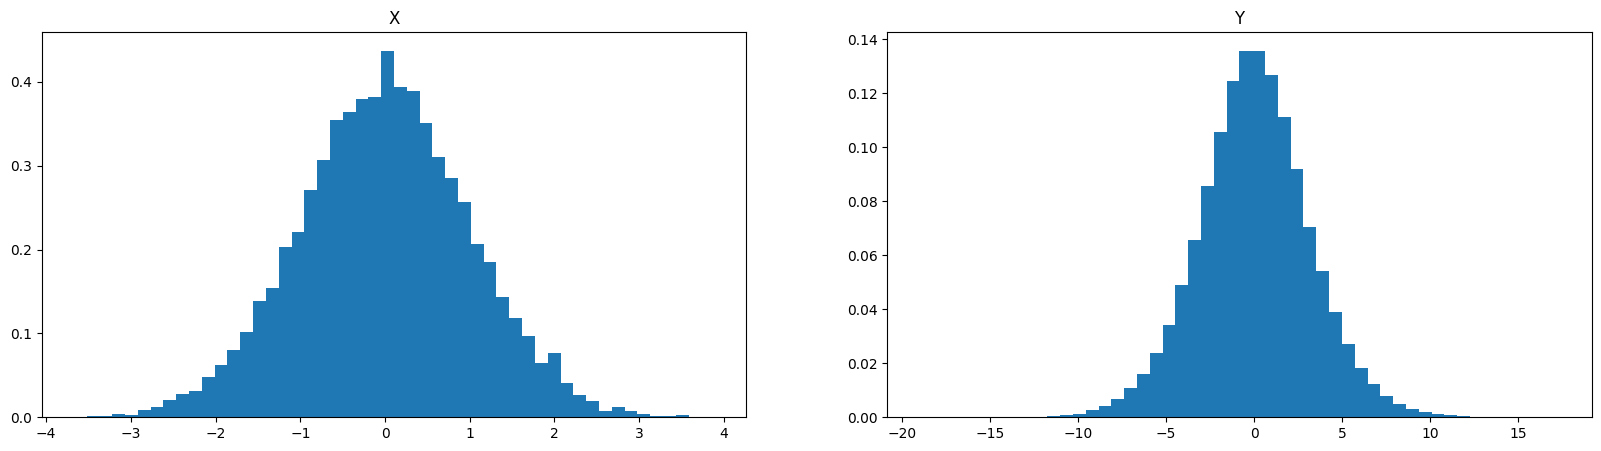

In [29]:
x = torch.randn(1000, 10) # 1000 vectors á 10 dimensions (inputs) (gaussian-distributed)
w = torch.randn(10, 200)  # 10 vectors á 200 dimensions (200 neurons, each looking at 10 inputs)

# [!] We leave out the biases b for this example

y = x @ w # Get the neurons pre-activations

print(f'X:', x.mean(), x.std())  # mean ~0, standard dev: ~1 (as this is Gaussian)
print(f'W:', w.mean(), w.std())  # mean ~0, standard dev: ~1 (also Gaussian)
print(f'Y:', y.mean(), y.std())  # mean ~0, standard dev: ~3 ?!

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('X')
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.title('Y')
plt.hist(y.view(-1).tolist(), 50, density=True);

The pre-activations have a *non*-Gaussian standard deviation now. This happens through the element-wise multiplication, but **we don't want that**.<br>
Normal distribution should ideally be maintained, because a flattened distribution causes more and more extreme values to occur, which in turn causes the gradient to be extremer more and more often.

**Our question is: How can we multiply `w` so that the standard deviation is still ~1 after `x @ w`?**

We achieve leverage by scaling `w`. If multiplied by e.g. $5$, the standard deviation further increases.<br>
If multiplied by e.g. $\frac{1}{5}$, the standard deviation decreases.

Mathematically, the correct factor given weights `w` is: $\frac{1}{\sqrt{w.shape[0]}}$ where **`w.shape[0]` is called the fan-in** of the layer.

X: tensor(0.0025) tensor(1.0009)
W: tensor(0.0067) tensor(0.3230)
Y: tensor(-0.0016) tensor(1.0208)


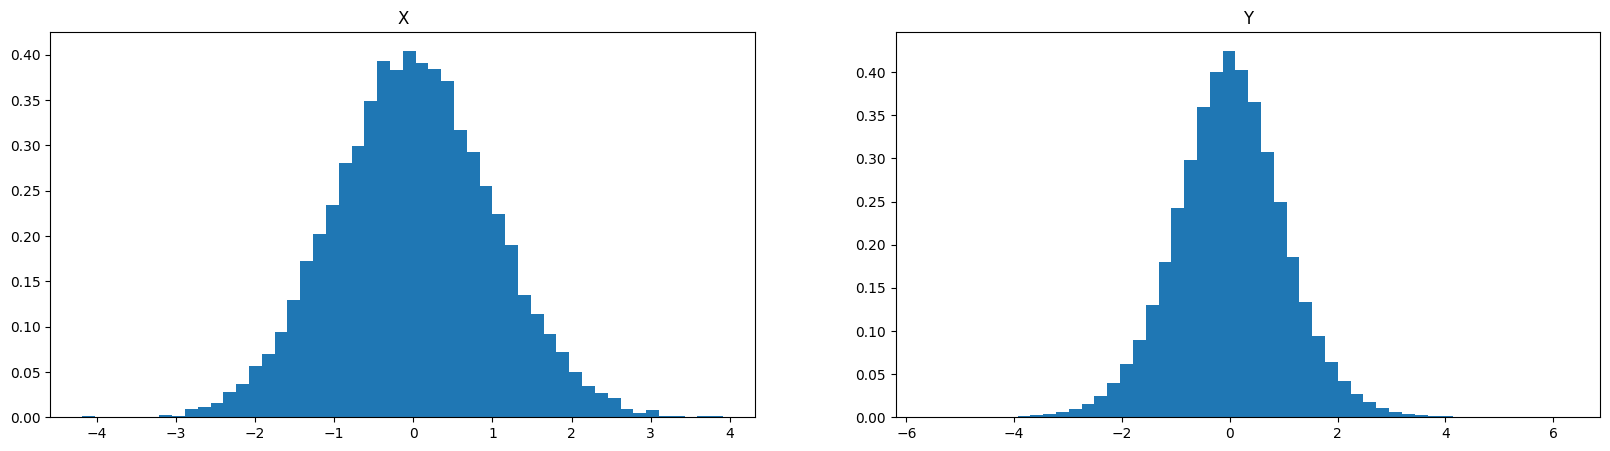

In [30]:
x = torch.randn(1000, 10) 
w = torch.randn(10, 200) * 10**-0.5 # meaning / sqrt(10) or 0.316228

y = x @ w

print(f'X:', x.mean(), x.std())
print(f'W:', w.mean(), w.std())
print(f'Y:', y.mean(), y.std())

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('X')
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.title('Y')
plt.hist(y.view(-1).tolist(), 50, density=True);

Several papers have looked at the problem of how to best initialize MLPs.<br>
The papers deal with how to best setup/initialize the weights (and scale them for different MLP sizes) so that they do not become infinitely small or incredibly large throughout the learning process.

[This paper by Kaiming He et al.](https://arxiv.org/abs/1502.01852) takes an intense look at CNNs and the ReLU and PReLU nonlinearities regarding this problem. (Not exactly light reading)

**But:** The initialization technique described in the paper is implemented in PyTorch - `torch.nn.init.kaiming_normal_`. **This is probably the most common way to initialize weights in PyTorch.**

Before this paper was published, deep MLPs were quite fragile.<br>But this paper started a "stabilization trend", which resulted in a wide variety of optimization and stabilization techniques such as:

- Residual Connections,
- Batch-Normalization,
- Layer-Normalization,
- Adam-Optimizer (and other optimizers make an exact initialization less important)

The paper states that we have to multiply the weights by a factor to achieve the desired standard deviation again. (see also [here](https://pytorch.org/docs/stable/nn.init.html))

![](./images/kaiming_normal.PNG)

According to the paper, the value for `gain` is to be chosen depending on the activation function.<br>
In the below table, we can see for our above `linear` approach (no activation function at all) a `gain` of $1$, which is what we already applied with $\frac{1}{\sqrt{fan-in}}$:

![](./images/gains.PNG)

If we now apply this initialization technique for `tanh` activation to a more cleaned up MLP, we get the following code:

In [31]:
n_embd = 10
n_hidden = 200

g  = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) # the factor makes the std of the output ~1
b1 = torch.randn(n_hidden,                        generator=g) * 0.01 # Small, but not 0
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # Small, but not 0
b2 = torch.randn(vocab_size,                      generator=g) * 0    # Biases are now all 0

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

Now that we have also optimized the value initialization of the weights, we of course have to train again:

In [32]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # X,Y of this batch
    
    # Forward-Pass
    emb = C[Xb]                         
    embcat = emb.view(emb.shape[0], -1) 
    hpreact = embcat @ W1 + b1          
    h = torch.tanh(hpreact)             
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    # Backward-Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    lr = 0.1 if i < (max_steps / 2) else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Printing track stats every once in a while
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    
    # Adding current loss value to historic losses set (for later display)
    lossi.append(loss.log10().item())

      0/ 200000: 3.3179
  10000/ 200000: 2.1910
  20000/ 200000: 2.3270
  30000/ 200000: 2.5396
  40000/ 200000: 1.9468
  50000/ 200000: 2.3331
  60000/ 200000: 2.3852
  70000/ 200000: 2.1173
  80000/ 200000: 2.3159
  90000/ 200000: 2.2010
 100000/ 200000: 1.8591
 110000/ 200000: 2.0881
 120000/ 200000: 1.9389
 130000/ 200000: 2.3913
 140000/ 200000: 2.0949
 150000/ 200000: 2.1458
 160000/ 200000: 1.7824
 170000/ 200000: 1.7249
 180000/ 200000: 1.9751
 190000/ 200000: 1.8614


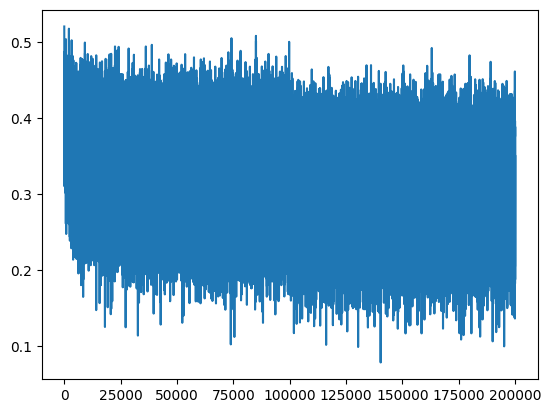

In [33]:
plt.plot(lossi);

In [34]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    
    emb = C[x]                          # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # Concatenate into (N, block_size * n_embd)
    
    h = torch.tanh(embcat @ W1 + b1)    # (N, n_hidden)
    logits = h @ W2 + b2                # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0376641750335693
val 2.106989622116089


| Losses | Original           | Solved Problem 1   | Solved Problem 2       | Solved Problem 1+2     |
| ------ | ------------------ | ------------------ | ---------------------- | ---------------------- |
| train  | 2.1255977153778076 | 2.069535732269287  | **2.0355823040008545** | 2.0376641750335693     |
| val    | 2.168022394180298  | 2.1311967372894287 | **2.1026716232299805** | 2.106989622116089      |

We end up roughly where we started. This is actually a good thing, because we no longer have a "magic number" that scales our weights.<br>
We simply calculated the scaling factor we are now using.

## Batch Normalization

The concept comes from [this paper by Ioffe and Szegedy](https://arxiv.org/abs/1502.03167) and makes the exact weight initialization, as we have done above, quasi obsolete/irrelevant.

In our NN, we have the hidden states `hpreact`, which we form into activations with `tanh`.<br>
The `hpreact`s should (we had already discussed this with `tanh` optimization) not be too small or not too large, so ideally normally distributed (standard deviation of $1$).
Above, we had taken a pretty verbose approach to achieve this. But imagine now that we hadn't, and that instead, we had just initialized the weights and biases randomly.

> **Batch Normalization says:** If we want the hidden states `hpreact` to be normally distributed, we can just like that transform/re-arrange from its current distribution into a normal distribution.<br>
> This is a differentiable operation, so backprop has no problem with it. This is allowed!

The paper lists a kind of "recipe" for how Batch Normalization works:<br>
![](./images/batch_norm_recipe.PNG)

Let's first take a look at `hpreact`:

In [35]:
print('hpreact shape:', hpreact.shape) # (32, 200)

hpreact shape: torch.Size([32, 200])


First, we calculate the mean along the zero-th dimension (the batch dimension) of `hpreact`:

In [36]:
# Step 1: Calculate the mean across 0th dimension
# The 0 indicates that we calculate the mean along the 32 inputs, so we get 200 means, one per neuron
print('mean:', hpreact.mean(0, keepdim=True).shape) # (1, 200)

mean: torch.Size([1, 200])


For step 2, we calculate the standard deviation along the zero-th dimension of `hpreact`:

In [37]:
# Step 2: Calculate the standard deviation across 0th dimension
# The 0 indicates that we calculate the mean along the 32 inputs, so we get 200 standard deviations, one per neuron
print('stddev:', hpreact.std(0, keepdim=True).shape) # (1, 200)

stddev: torch.Size([1, 200])


With these tools in hand, we can now calculate the batch-normalized `hpreact` in step 3:

In [38]:
# Step 3: Normalizing just like the recipe describes
hpreact = (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) # (32, 200)
print(hpreact.shape)

torch.Size([32, 200])


The above operations normalize the values of the $200$ neurons in `hpreact` across the $32$ inputs in the batch.<br>
This means that the activations of all neurons are maximally/minimally as strongly/weakly pronounced by the inputs as the normal distribution allows them to be.

If you were to use the `hpreact` from the above `Step 3` as-is inside the forward pass<br>
as `hpreact = (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True)`, the MLP's performance would be **worse actually**.<br>
The reason for this is that we actually only want these (restrictively) normally distributed activations of the hidden layer **once, during MLP initialization**.

> Batch-Normalization is supposed to create a level playing field for the training process by normalizing the activations initially **and only initially**.<br>
> During training, the activation should then be adjusted to the inputs exclusively and fully by backprop.

This is exactly what `Step 4` from the above "recipe" allows for.<br>
We need new variables in this step. We need a scaler `bngain` and an offset `bnbias`.<br>
This is best shown if we set up the MLP again:

In [39]:
n_embd = 10
n_hidden = 200

g  = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # Small, but not 0
b2 = torch.randn(vocab_size,                      generator=g) * 0    # Biases are now all 0

bngain = torch.ones((1, n_hidden))  # (1, 200), a 1 for each hidden neuron
bnbias = torch.zeros((1, n_hidden)) # (1, 200), a bias for each hidden neuron

parameters = [C, W1, b1, W2, b2, bngain, bnbias] # gain and bias are change from backprop!!

for p in parameters:
    p.requires_grad = True

During initialization, `bngain` only consists of ones, one for each neuron. `bnbias` holds a zero for each neuron.<br>
We apply `bngain` and `bnbias` to our `hpreact` for a first time like so:

```python
hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
```

The result is exactly the same as before, **especially because `bngain` consists of ones and `bnbias` consists of zeros only**.

> The trick now is that `bngain` and `bnbias` change from initialization onwards because we include them in `parameters`.<br>
> This means that - exactly as we need it - no strict normal distribution is enforced in `hpreact` during training,<br>
> but rather the network can now adjust `bngain` and `bnbias` as it pleases.<br>
> This provides the training process with an ajustable grip on the distribution of the activations itself.

To complete `Step 4` from the "recipe", we now apply `bngain` and `bnbias` to `hpreact`:

In [40]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # X,Y of this batch
    
    # Forward-Pass
    emb = C[Xb]                         
    embcat = emb.view(emb.shape[0], -1) 
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    h = torch.tanh(hpreact)             
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    # Backward-Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    lr = 0.1 if i < (max_steps / 2) else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Printing track stats every once in a while
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    
    # Adding current loss value to historic losses set (for later display)
    lossi.append(loss.log10().item())

      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


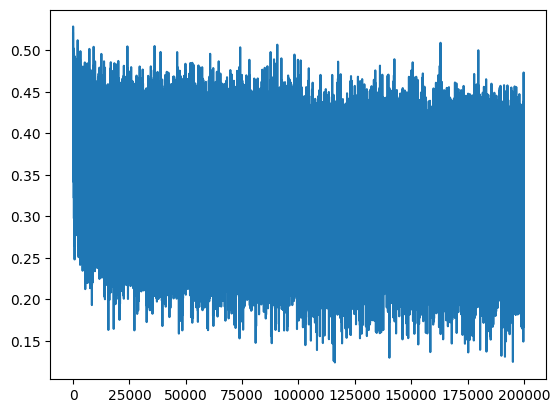

In [41]:
plt.plot(lossi);

In [42]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    
    emb = C[x]                          # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # Concatenate into (N, block_size * n_embd)
    
    # This part is new, just like we did with our new Batch Normalized NN
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    
    h = torch.tanh(hpreact)             # (N, n_hidden)
    logits = h @ W2 + b2                # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0668270587921143
val 2.104844808578491


| Losses | Original           | Solved Problem 1   | Solved Problem 2       | Solved Problem 1+2 | Batch-Norm          | 
| ------ | ------------------ | ------------------ | ---------------------- | ------------------ | ------------------- |
| train  | 2.1255977153778076 | 2.069535732269287  | **2.0355823040008545** | 2.0376641750335693 | 2.0668270587921143  |
| val    | 2.168022394180298  | 2.1311967372894287 | **2.1026716232299805** | 2.106989622116089  | 2.104844808578491   |

In fact, we do **not** expect a great improvement in the performance/quality of the model with Batch-Normalization.<br>
**This is simply because our MLP is too flat for Batch-Normalization to have a big impact.**

>The deeper the MLP and the more intertwined, the more difficult it becomes to manipulate the weights (as done above with the factors before we did the Batch-Normalization).<br>
>But the more that is the case, the more Batch-Normalization pays off. You don't have to do Batch-Normalization with every layer, but you should do it with linear layers ($Wx+b$) or convolutional layers

### The Cost of Batch-Normalization

**Batch-Normalization comes at a cost, a high cost:**<br>
So far, we viewed at each point a single input example, whose activations were calculated - deterministically, i.e. uniquely determined by this single input.<br>
We had already split the training into batches of inputs. This was done for efficiency reasons (stochastic gradient descent) in Makemore 2, which contributed to the training process being more stable.

**Batch-Normalization messes with these ideas.**<br>
Because `hpreact` is gradually moving away from the normal distribution through backprop, being in a batch now has a meaning. There is a connection between the inputs in a batch.

> The logits are now no longer "only" the deterministic result of a single input; They are the result of the input **and** the previous inputs in the training batch, which the batch normalization "deformed" into their current state. **The batch counts, not just the atomic training example.**

This means that if you change the batch composition and then give the same input to the MLP, the logits will "wobble" in their values from batch composition to batch composition.<br>
This *jitter* is not only observed in the `logits`, but also in `h`.

**Is this good? Actually yes!**

Because of this training history-related "wobbling", the MLP now has a natural **entropy**.<br>
And that in turn makes overfitting less likely. Noise kills overfitting.

![](./images/entropy.PNG)

> Batch-Normalization is such a good regularizer that you can't imagine training without it anymore. It stabilizes training and makes overfitting less likely.

Actually, this is not the only effect of Batch-Normalization.<br><br>
Let's take a step further in the life cycle of an MLP: When we deploy an MLP, we expect *one* output/prediction for *one* input.<br>
We expect deterministic behavior.

**Problem:**<br>
How is this supposed to work with active Batch-Normalization, if it evaluates the history of the previous inputs (which we don't have in the production environment) and therefore expects batches as input and exerts a batch-dependent influence on the output?

**Solution:**<br>
After the actual training and before "going live", the mean and standard deviation are set once in the Batch-Normalization layers. Once, over the entire training set. Set in stone, this effectively halts batch-dependencies.

We have already trained a batch-normalized MLP above. We now tie in with the new determination and performance evaluation process:

In [43]:
# New: Calibrate the batch norm at the end of training
with torch.no_grad(): # this makes everything below faster, as "bookkeeping" is turned off
    # pass the (entire) training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean/std over the entire training set ONCE (cast them into stone)
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [44]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    
    emb = C[x]                          # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # Concatenate into (N, block_size * n_embd)
    
    # This part is new, just like we did with our new Batch Normalized NN
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias # Fix them, hold them, technologic
    
    h = torch.tanh(hpreact)             # (N, n_hidden)
    logits = h @ W2 + b2                # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0668270587921143
val 2.104926586151123


We get the same performance as with the immediate measurement of the batch-normalized model. That's good, we can now evaluate individual inputs through this.

However, it is actually the case that our current process - definition, training, freezing of `bnmean` and `bnstd`, evaluation - is not quite used like that in reality.<br>
In fact, `bnmean` and `bnstd` can already be estimated **during** the training of the MLP.

Definition and training process have to be adjusted for this.<br>
It helps to know that `hpreact` is normally distributed at initialization, so the mean will be $\sim 0$ and the standard deviation will be $\sim1$.<br>
We add two variables `bnmean_running` initialized with zeros and `bnstd_running` initialized with ones
to keep a running average of the mean and standard deviation of `hpreact` during training across the batches.<br>
Per individual step/batch, we calculate `bnmeani` and `bnstdi` for this batch and then update `bnmean_running` and `bnstd_running` with the following formula, outside the gradient calculation:

```python
bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
```

Definition and training process now look like this:

In [45]:
n_embd = 10
n_hidden = 200

# Initializations
g  = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.01 
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # Small, but not 0
b2 = torch.randn(vocab_size,                      generator=g) * 0    # Biases are now all 0

bngain = torch.ones((1, n_hidden))  # 1 x 200, a 1 for each hidden neuron
bnbias = torch.zeros((1, n_hidden)) # 1 x 200, a bias for each hidden neuron

# These two don't require gradient derivation (not added to 'parameters')
bnmean_running = torch.zeros((1, n_hidden)) # hpreact starts as normal. distr. -> mean is 0
bnstd_running = torch.ones((1, n_hidden))   # hpreact starts as normal. distr. -> stddev is 1

parameters = [C, W1, b1, W2, b2, bngain, bnbias] # gain and bias are changed by backprop!!

for p in parameters:
    p.requires_grad = True

In [46]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # X,Y of this batch
    
    # Forward-Pass
    emb = C[Xb]                         
    embcat = emb.view(emb.shape[0], -1) 
    hpreact = embcat @ W1 + b1
    
    # New: Mean and stddev definitions are outsourced to here
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    
    with torch.no_grad(): # This has nothing to do with gradient updating
        # Adding up small updates in the direction of current mean and stddev
        # This will build up to form a total mean and stddev right after training
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    
    h = torch.tanh(hpreact)             
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    # Backward-Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    lr = 0.1 if i < (max_steps / 2) else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Printing track stats every once in a while
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    
    # Adding current loss value to historic losses set (for later display)
    lossi.append(loss.log10().item())

      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


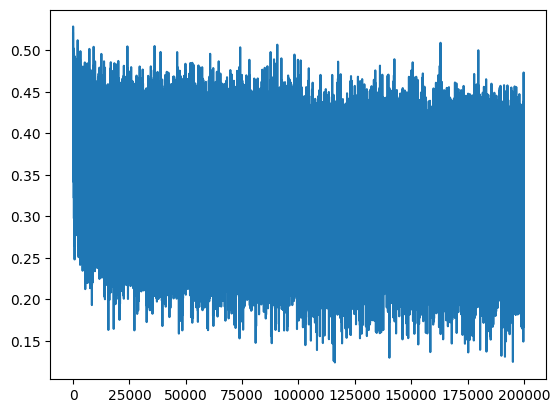

In [47]:
plt.plot(lossi);

In [48]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    
    emb = C[x]                          # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # Concatenate into (N, block_size * n_embd)
    
    # This part is new, just like we did with our new Batch Normalized NN
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    
    h = torch.tanh(hpreact)             # (N, n_hidden)
    logits = h @ W2 + b2                # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.066591739654541
val 2.1050572395324707


| Losses | Original           | Solved Problem 1   | Solved Problem 2       | Solved Problem 1+2 | Batch-Norm          | Running Batch-Norm |
| ------ | ------------------ | ------------------ | ---------------------- | ------------------ | ------------------- | ------------------ |
| train  | 2.1255977153778076 | 2.069535732269287  | **2.0355823040008545** | 2.0376641750335693 | 2.0668270587921143  | 2.066591739654541  |
| val    | 2.168022394180298  | 2.1311967372894287 | **2.1026716232299805** | 2.106989622116089  | 2.104844808578491   | 2.1050572395324707 |

`bnmean` and `bnmean_running` as well as `bnstd` and `bnstd_running` are not identical, but very close to each other. This is sufficient for us. We have effectively skipped or integrated the "Freezing" step and no longer need it as such.

Actually, our current approach is **still not perfect, but in a *very* subtle way**.<br>
Currently, we determine `hpreact` by calculating `embcat @ W1 + b1`.<br>
Then we determine the mean (of all pre-activation values of all current neurons together) for `hpreact` and subtract it from `hpreact`.<br>
So we add `b1`, intentionally shifting the mean (of all neurons) per neuron, but then subtract this mean from `hpreact`, so that the neuron gets a guaranteed mean of $0$.<br>
Thus no intended shift through `b1` can take place.<br>
Batch-Normalization gives us the opportunity to "distort as usual" after the actual normalization with `bnbias`.<br>
In other words, we don't need `b1` anymore, as `bnbias` can do the same job.

Finally, a complete, more optimal implementation with Batch-Normalization without `b1`:

In [49]:
n_embd = 10
n_hidden = 200

# Initializations
g  = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
# b1 = torch.randn(n_hidden,                        generator=g) * 0.01 # Turned off as not needed anymore (bnbias does the job)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # Small, but not 0
b2 = torch.randn(vocab_size,                      generator=g) * 0    # Biases are now all 0

bngain = torch.ones((1, n_hidden))  # 1 x 200, a 1 for each hidden neuron
bnbias = torch.zeros((1, n_hidden)) # 1 x 200, a bias for each hidden neuron

# These two don't require gradient derivation (not added to 'parameters')
bnmean_running = torch.zeros((1, n_hidden)) # hpreact starts as normal. distr. -> mean is 0
bnstd_running = torch.ones((1, n_hidden))   # hpreact starts as normal. distr. -> stddev is 1

parameters = [C, W1, W2, b2, bngain, bnbias] # gain and bias are changed by backprop!!

for p in parameters:
    p.requires_grad = True

In [50]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # X,Y of this batch
    
    # Forward-Pass
    emb = C[Xb]                         
    embcat = emb.view(emb.shape[0], -1) 
    
    # Linear Layer
    hpreact = embcat @ W1 #+ b1
    
    # Batch Normalization Layer
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    with torch.no_grad(): # This has nothing to do with gradient updating
        # Adding up small updates in the direction of current mean and stddev
        # This will build up to form a total mean and stddev right after training
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    # Non-Linearity
    h = torch.tanh(hpreact)             
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    # Backward-Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    lr = 0.1 if i < (max_steps / 2) else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Printing track stats every once in a while
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    
    # Adding current loss value to historic losses set (for later display)
    lossi.append(loss.log10().item())

      0/ 200000: 3.3239
  10000/ 200000: 2.0322
  20000/ 200000: 2.5675
  30000/ 200000: 2.0125
  40000/ 200000: 2.2446
  50000/ 200000: 1.8897
  60000/ 200000: 2.0785
  70000/ 200000: 2.3681
  80000/ 200000: 2.2918
  90000/ 200000: 2.0238
 100000/ 200000: 2.3673
 110000/ 200000: 2.3132
 120000/ 200000: 1.6413
 130000/ 200000: 1.9311
 140000/ 200000: 2.2231
 150000/ 200000: 2.0027
 160000/ 200000: 2.0997
 170000/ 200000: 2.4949
 180000/ 200000: 2.0199
 190000/ 200000: 2.1707


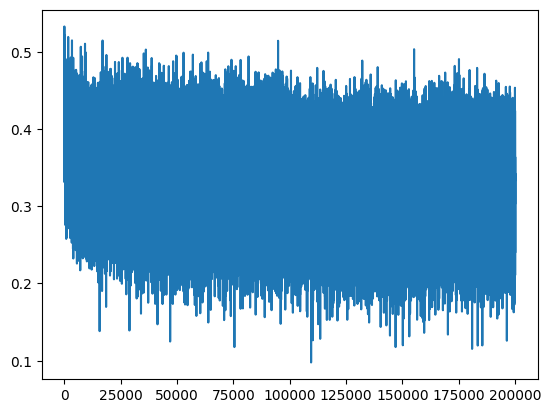

In [51]:
plt.plot(lossi);

In [52]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    
    emb = C[x]                          # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # Concatenate into (N, block_size * n_embd)
    
    # This part is new, just like we did with our new Batch Normalized NN
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    
    h = torch.tanh(hpreact)             # (N, n_hidden)
    logits = h @ W2 + b2                # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0674195289611816
val 2.105670690536499


---

## Digression: Convolutional Layers

The architecture of most current models (see [example](https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py)) follows the basic structure that the above mini-model also has:

- For x times:
    - linear layer
    - batch-normalization
    - Activation function (e.g. tanh, relu; non-linearity)
    
Oftentimes, the linear layer is a convolutional layer.

> Convolutional Layers are linear layers, but they are specifically used for image data.<br>
> They have a spatial structure, meaning that the operation $W*x+b$ is performed per a partial image patch and not the entire image at once.<br>
> These patches can overlap in part. This is configurable.

In PyTorch, Convolutional Layers are defined in the class `nn.Conv2d`.

---

## Linear Layers in PyTorch

[Linear Layers](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) perform a calculation $W*x+b$. To be able to create such layers through PyTorch, you need to know the following prerequisites:

- in_features (**fan-in**, the dimensions/size of a single input (above it was 10x3))
- out_features (**fan-out**, the dimensions/size of a single output (above it was 200))
- bias (`True` or `False`, `False` per Default)

This will create a `Linear.weight` and a `Linear.bias` variable.

Here's the example from the official documentation:

In [53]:
m = torch.nn.Linear(10*3, 200) # Dimensions chosen to look just like our example
input = torch.randn(100, 30)   # 100 30-dimensional inputs, randomly generated
output = m(input)              # Feed inputs into the layer
print(output.size())           # we now should have 100 times 200 'neuron reactions'

torch.Size([100, 200])


## Batch-Normalization in PyTorch

There is also a [PyTorch class](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html?highlight=batchnorm1d) for this NN layer.

We need for such a `BatchNorm1d`-layer:
- `num_features` - The number of features/dimensions of an input
- (`epsilon` - This is already set with a small default value, let's leave it like that)
- `momentum` - This is the factor by which the current `mean` and `std` contribute to `running_mean` and `running_std` (for us this factor was $0.001$, default is $0.1$)

> The smaller the dataset, the smaller the `momentum` should be defined.

- `affine` - (Default) True, if `bngain` and `bnbias` should exist
- `track_running_stats` - (Default) True, if `bnmean_running` and `bnstd_running` should exist and be aggregated internally

Here's the example from the official documentation:

In [54]:
# With 200 Learnable Parameters
m = torch.nn.BatchNorm1d(200) # Batch-Normalization receives 200 inputs, like in example above
# Without Learnable Parameters (not the usual thing to do tbh)
# m = nn.BatchNorm1d(200, affine=False)
input = torch.randn(20, 200)  # Let's throw in 20 inputs á 200 dimensions
output = m(input)
print(output)
print(output.shape) # 20 x 200, unchanged

tensor([[ 1.2777,  0.1959,  0.1647,  ...,  0.1531, -1.3173,  0.8623],
        [-0.4298,  1.4393, -0.9352,  ..., -1.2674, -0.4257, -1.0160],
        [ 0.5344,  0.4357,  1.3319,  ...,  0.2893, -0.8796, -0.1071],
        ...,
        [-1.0832,  0.3031, -0.3014,  ...,  0.1558,  0.3190,  1.6866],
        [-0.0940, -0.0975,  1.0661,  ...,  1.2521,  2.1717,  2.0989],
        [-0.4835,  0.1759, -1.2000,  ..., -0.0109, -1.0099, -0.7396]],
       grad_fn=<NativeBatchNormBackward0>)
torch.Size([20, 200])


> Actually, due to Batch-Normalization "Batch-ifying" the view on data and its training effects, it can really come around and turn problematic quickly.<br>
> **Try to avoid Batch-Normalization.** Try to instead use Group normalization or layer normalization.

## Rebuilding the example in PyTorch

The example below is strongly based on our previous model.<br>
But now we also take a closer look at the effect of the Batch-Normalization layers.<br>
To do this, we first build the network layers as modular classes.<br>
Then we build an NN *without* Batch-Normalization and look at properties and possible problems.<br>
Then we build a second PyTorch model, but with Batch-Normalization layers.

In [55]:
# Linear Layer Definition (mimicing torch.nn.Linear's structure)
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    # Weights with Kaiming just like above would be (W1 * (5/3)/((n_embd * block_size)**0.5))
    # The term (5/3) is still missing, but that's because we don't have a non-linearity here yet
    # We'll add it later
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in ** 0.5
    self.bias = torch.zeros(fan_out) if bias else None # Biases are optional here
  
  def __call__(self, x):
    self.out = x @ self.weight # W*x
    if self.bias is not None:  # Add biases if so desired
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias]) # return layer's tensors

In [56]:
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps            # Epsilon set to PyTorch default, you may change it
    self.momentum = momentum  # Momemtum set to PyTorch default, you may change it
    self.training = True
    # Initialize Parameters (trained with backprop)
    # (bngain -> gamma, bnbias -> beta)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # Initialize Buffers 
    # (Trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  

  def __call__(self, x):
    # Forward-Pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # Batch mean
      xvar = x.var(0, keepdim=True)   # Batch variance
    else:
      xmean = self.running_mean # Using the running mean as basis
      xvar = self.running_var   # Using the running variance as basis
    
    # Normalize to unit variance
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
    self.out = self.gamma * xhat + self.beta  # Apply batch gain and bias
    
    # Update the running buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    
    return self.out
  

  def parameters(self):
    return [self.gamma, self.beta] # return layer's tensors

In [57]:
# Similar to torch.tanh(), but Class-structure to make later steps easier
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

### Activation Distribution for MLP with Tanh and Correct Gain

In [58]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd), generator=g)

layers = [
  Linear(n_embd * block_size, n_hidden),  Tanh(),
  Linear(           n_hidden, n_hidden),  Tanh(),
  Linear(           n_hidden, n_hidden),  Tanh(),
  Linear(           n_hidden, n_hidden),  Tanh(),
  Linear(           n_hidden, n_hidden),  Tanh(),
  Linear(           n_hidden, vocab_size),
]

with torch.no_grad():
  # Last layer: make less confident
  layers[-1].weight *= 0.1
  # All other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

# Embedding matrix + all parameters in all layers = total involved parameters
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total

# These parameters will be affected by backpropagation
for p in parameters:
  p.requires_grad = True

46497


In [59]:
# Same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # Minibatch-Construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # Batch X,Y
  
    # Forward-Pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Stack up the layers in orginal order (one after another)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function
  
    # Backward-Pass
    for layer in layers:
        # Stating that non-leaf variable gradients are to be kept/retained for evaluation
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()
  
    # Update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # Tracking stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())
        
    break # Take this out to run full optimization/training

      0/ 200000: 3.2962


layer 1 (      Tanh): mean -0.02, std 0.75, saturated: 20.25%
layer 3 (      Tanh): mean -0.00, std 0.69, saturated: 8.38%
layer 5 (      Tanh): mean +0.00, std 0.67, saturated: 6.62%
layer 7 (      Tanh): mean -0.01, std 0.66, saturated: 5.47%
layer 9 (      Tanh): mean -0.02, std 0.66, saturated: 6.12%


Text(0.5, 1.0, 'Activation Distribution')

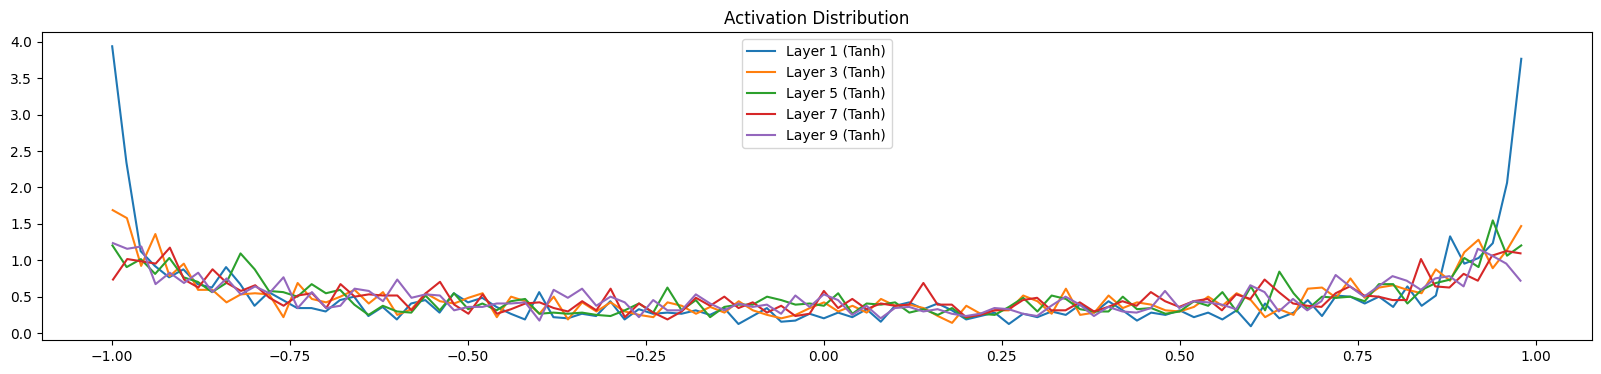

In [60]:
# Visualize histograms (forward pass activations) for the Tanh layers
# (below is what it looks like when Batch-Normalization is needed)
# We can see how many tensor values take on which x-axis values
plt.figure(figsize=(20, 4)) # Width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # Note: Excluding the output layer, these are all Tanh layers
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'Layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('Activation Distribution')

The graph shows us the range of values of the individual layers (except the output layer). This means that we can see how many tensors per layer take which x-axis values.<br>

Especially in Layer $1$, we can see our well familiar problem: Lots of neurons are compressed into the boundaries of the Tanh value range.<br>
And you can also see this in the percentage values, because $20.25\%$ of the neurons have a `Tanh` value that is above $0.97$ in the absolute.<br>
This is bad, because we block the learning effect of the gradients with it, dulling the learning process.

Interestingly, this effect is limited to the first layer. The subsequent layers look good. **But why is that?**

Gain is set to a value of `5/3`, because we have a `Tanh` activation function. This is the value that is recommended for `Tanh` in the paper by Kaiming He et al. (see above),
but is also the reason.
Let's see what would happen if we set Gain to `1.0`:

### Activation Distribution for MLP with Tanh and Too Small Gain

In [61]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd), generator=g)

layers = [
  Linear(n_embd * block_size, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size),
]

with torch.no_grad():
  # Last layer: make less confident
  layers[-1].weight *= 0.1
  # All other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1 # 5/3 is replaced by gain of 1

# Embedding matrix + all parameters in all layers = total involved parameters
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total

# These parameters will be affected by backpropagation
for p in parameters:
  p.requires_grad = True

46497


In [62]:
# Same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # Minibatch-Construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # Batch X,Y
  
    # Forward-Pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Stack up the layers in orginal order (one after another)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function
  
    # Backward-Pass
    for layer in layers:
        # Stating that non-leaf variable gradients are to be kept/retained for evaluation
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()
  
    # Update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # Tracking stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())
        
    break # Take this out to run full optimization/training

      0/ 200000: 3.2988


layer 1 (      Tanh): mean -0.02, std 0.62, saturated: 3.50%
layer 3 (      Tanh): mean -0.00, std 0.48, saturated: 0.03%
layer 5 (      Tanh): mean +0.00, std 0.41, saturated: 0.06%
layer 7 (      Tanh): mean +0.00, std 0.35, saturated: 0.00%
layer 9 (      Tanh): mean -0.02, std 0.32, saturated: 0.00%


Text(0.5, 1.0, 'Activation Distribution')

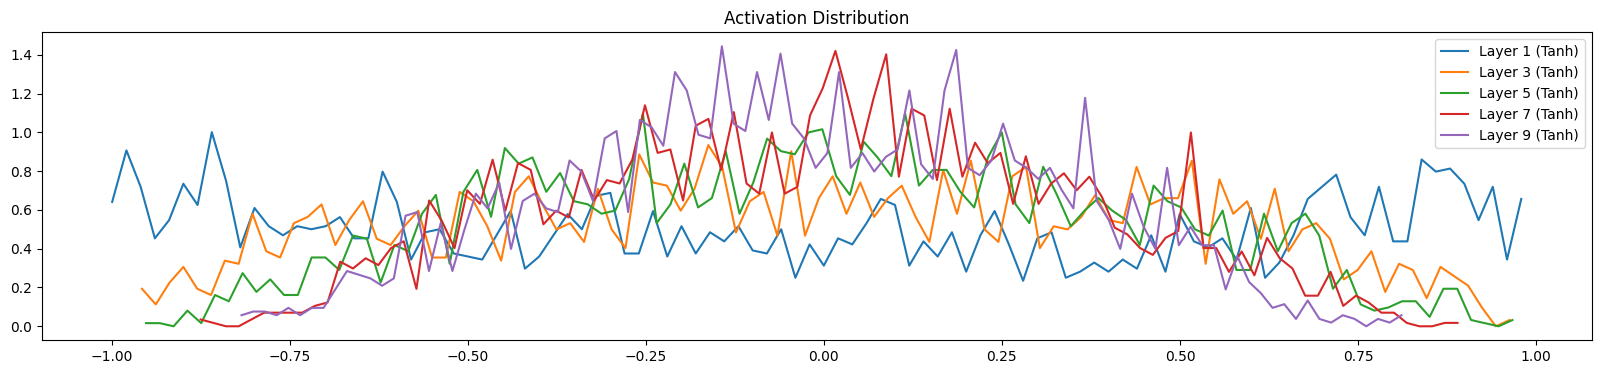

In [63]:
# Visualize activation histogram (i.e. activations) for the Tanh layers
# (below is what a worst-case looks like)
# We can see how many tensor values take on which x-axis values
plt.figure(figsize=(20, 4)) # Width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # Note: Excluding the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'Layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('Activation Distribution')

Without a $gain$, the standard deviation of the activations now **decreases** with each layer. It's not maintained to be $1$ anymore.<br>
Now the first layer looks the "most normal" and the subsequent layers are more and more compressed into the center, $0$, of the `Tanh` value range.

In fact, this trend continues until the standard deviation is $0$.<br>
The `Tanh` functions between the Linear Layers compress and are therefore responsible for this effect and its increase.

> For models that are a "sandwich" of linear layers and `tanh` layers, $\frac{5}{3}$ is a good value for the gain. Where does it come from? No idea. 
> But we see in the penultimate graph that the effect of $Gain = \frac{5}{3}$ is exactly what we need, namely that the standard deviation is maintained at $1$.

Good. Those were the **activations** of the neurons per layer.<br>
Now let's look at the **gradients** per layer for the model with $Gain = \frac{5}{3}$:

### Gradient Distribution for MLP with Tanh and Correct Gain

In [64]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd), generator=g)

layers = [
  Linear(n_embd * block_size, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size),
]

with torch.no_grad():
  # Last layer: make less confident
  layers[-1].weight *= 0.1
  # All other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

# Embedding matrix + all parameters in all layers = total involved parameters
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total

# These parameters will be affected by backpropagation
for p in parameters:
  p.requires_grad = True

46497


In [65]:
# Same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # Minibatch-Construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # Batch X,Y
  
    # Forward-Pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Stack up the layers in orginal order (one after another)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function
  
    # Backward-Pass
    for layer in layers:
        # Stating that non-leaf variable gradients are to be kept/retained for evaluation
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()
  
    # Update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # Tracking stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())
        
    break # Take this out to run full optimization/training

      0/ 200000: 3.2962


layer 1 (      Tanh): mean +0.000010, std 4.205588e-04
layer 3 (      Tanh): mean -0.000003, std 3.991179e-04
layer 5 (      Tanh): mean +0.000003, std 3.743020e-04
layer 7 (      Tanh): mean +0.000015, std 3.290473e-04
layer 9 (      Tanh): mean -0.000014, std 3.054035e-04


Text(0.5, 1.0, 'Gradient Distribution')

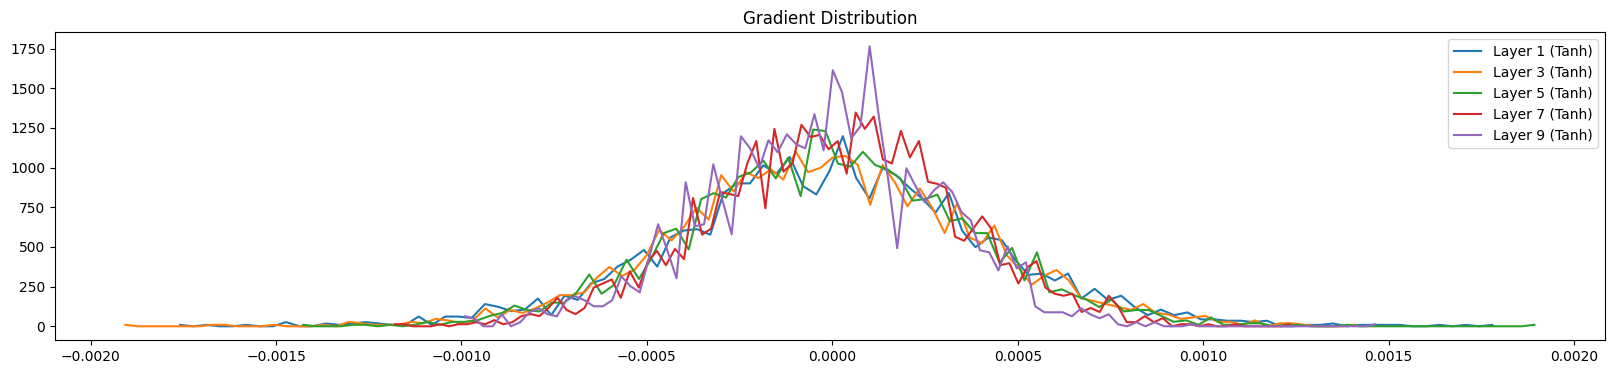

In [66]:
# Visualize Gradient Histogram (below is what it looks like ideally)
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'Layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('Gradient Distribution')

This looks pretty good, because over the layers distributed happens ... nothing unusual.<br>
The gradients should form a (common) bell curve over the layers. This is the case.

**When would you see something different than in the above graph?**<br>
The bell curves would look different, **if the $Gain$ is chosen too small or too large**.<br>
It would look like this:

### Gradient Distribution for MLP with Tanh and Too Small Gain

In [67]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd), generator=g)

layers = [
  Linear(n_embd * block_size, n_hidden),  Tanh(),
  Linear(           n_hidden, n_hidden),  Tanh(),
  Linear(           n_hidden, n_hidden),  Tanh(),
  Linear(           n_hidden, n_hidden),  Tanh(),
  Linear(           n_hidden, n_hidden),  Tanh(),
  Linear(           n_hidden, vocab_size),
]

with torch.no_grad():
  # Last layer: make less confident
  layers[-1].weight *= 0.1
  # All other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 0.5

# Embedding matrix + all parameters in all layers = total involved parameters
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total

# These parameters will be affected by backpropagation
for p in parameters:
  p.requires_grad = True

46497


In [68]:
# Same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # Minibatch-Construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # Batch X,Y
  
    # Forward-Pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Stack up the layers in orginal order (one after another)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function
  
    # Backward-Pass
    for layer in layers:
        # Stating that non-leaf variable gradients are to be kept/retained for evaluation
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()
  
    # Update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # Tracking stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())
        
    break # Take this out to run full optimization/training

      0/ 200000: 3.2960


layer 1 (      Tanh): mean +0.000000, std 1.892402e-05
layer 3 (      Tanh): mean -0.000001, std 3.943546e-05
layer 5 (      Tanh): mean +0.000004, std 8.035369e-05
layer 7 (      Tanh): mean +0.000009, std 1.561151e-04
layer 9 (      Tanh): mean -0.000014, std 3.053498e-04


Text(0.5, 1.0, 'Gradient Distribution')

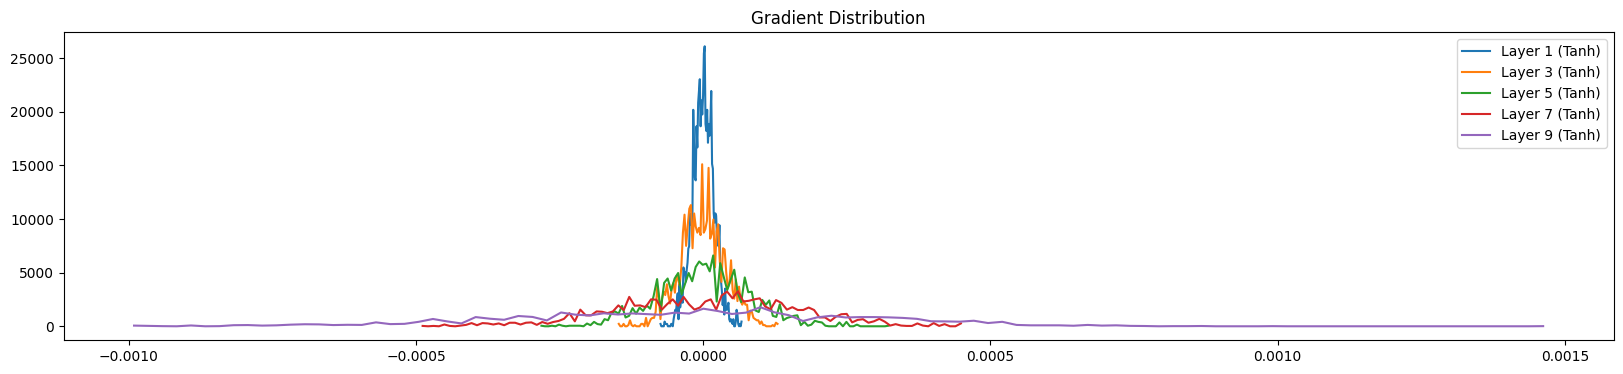

In [69]:
# Visualize Gradient Histogram
# (below is what you don't want it to look like)
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'Layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('Gradient Distribution')

This uneven gradient distribution per layer (across its neurons) is avoided by $Gain = \frac{5}{3}$. Good.

> We see that the gain must be searched very precisely for the correct effect on activations and gradients, **if we do *not* use batch normalization**.

Ok, but before we add batch layers, we should look at what happens if you only use linear layers and not even `Tanh` layers anymore:

### Activation Distribution for MLP without Tanh and Too Small Gain

In [70]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd), generator=g)

layers = [
  Linear(n_embd * block_size, n_hidden),
  Linear(           n_hidden, n_hidden),
  Linear(           n_hidden, n_hidden),
  Linear(           n_hidden, n_hidden),
  Linear(           n_hidden, n_hidden),
  Linear(           n_hidden, vocab_size),
]

with torch.no_grad():
  # Last layer: make less confident
  layers[-1].weight *= 0.1
  # All other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 0.5

# Embedding matrix + all parameters in all layers = total involved parameters
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total

# These parameters will be affected by backpropagation
for p in parameters:
  p.requires_grad = True

46497


In [71]:
# Same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # Minibatch-Construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # Batch X,Y
  
    # Forward-Pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Stack up the layers in orginal order (one after another)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function
  
    # Backward-Pass
    for layer in layers:
        # Stating that non-leaf variable gradients are to be kept/retained for evaluation
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()
  
    # Update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # Tracking stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())
        
    break # Take this out to run full optimization/training

      0/ 200000: 3.2959


layer 0 (    Linear): mean -0.01, std 0.49, saturated: 5.06%
layer 1 (    Linear): mean -0.00, std 0.25, saturated: 0.00%
layer 2 (    Linear): mean -0.00, std 0.13, saturated: 0.00%
layer 3 (    Linear): mean +0.00, std 0.06, saturated: 0.00%
layer 4 (    Linear): mean -0.00, std 0.03, saturated: 0.00%


Text(0.5, 1.0, 'Activation Distribution')

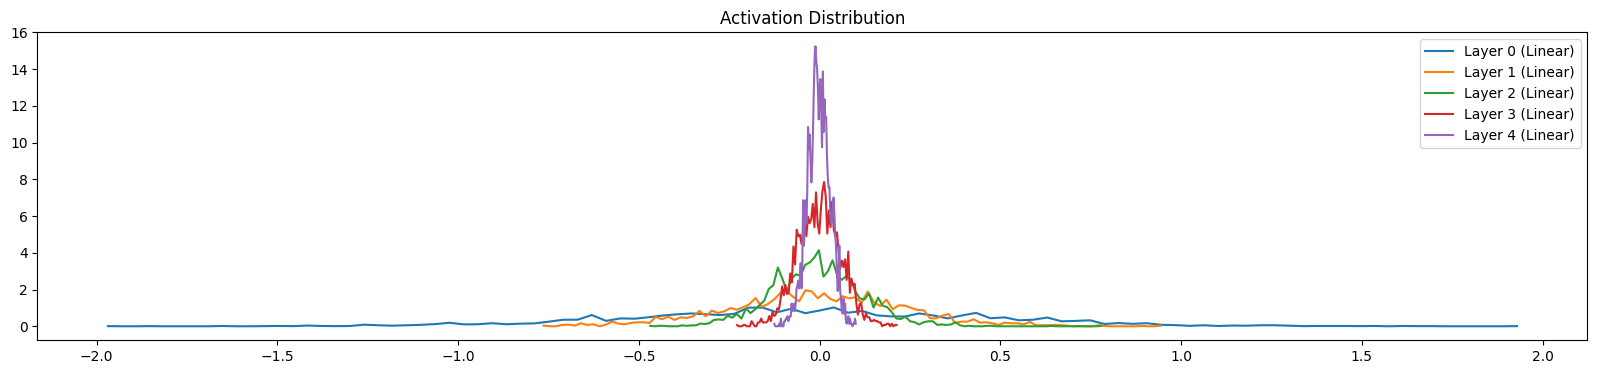

In [72]:
# Visualize activation histogram (i.e. activations) for the Linear layers
# (below is what it you don't want it to look like)
# High activation in deeper network parts only

# We can see how many tensor values take on which x-axis values
plt.figure(figsize=(20, 4)) # Width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # Note: Excluding the output layer
  if isinstance(layer, Linear):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'Layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('Activation Distribution')

layer 0 (    Linear): mean +0.000000, std 1.990759e-05
layer 1 (    Linear): mean -0.000001, std 3.997084e-05
layer 2 (    Linear): mean +0.000004, std 8.058026e-05
layer 3 (    Linear): mean +0.000009, std 1.562154e-04
layer 4 (    Linear): mean -0.000014, std 3.053490e-04


Text(0.5, 1.0, 'Gradient Distribution')

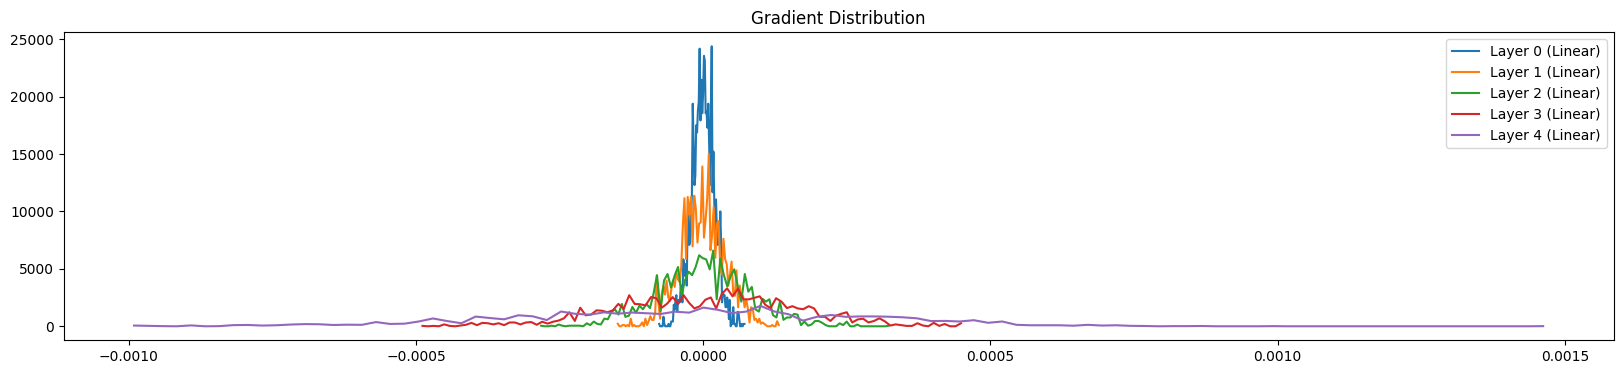

In [73]:
# Visualize Gradient Histogram
# (below is what you don't want it to look like)
# High Gradients (therefore large updates) only in shallow layers

plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Linear):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'Layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('Gradient Distribution')

We can observe the worst-case scenario here.<br>
Without `Tanh`, the activations and learning effects in the network decrease the deeper you go.<br>
Such an approach is therefore unusable, as it is not scalable. In addition, the learning effect is significantly lower.<br>
**The performance decreases significantly if you don't use `Tanh` here.**

(The correct gain for a pure linear layer NN would be $1$, but just saying)

Without Batch-Normalization, it is not only finding the most effective layers, **but also** setting the right gain, making the entire process more of a balancing act.

![](https://image.shutterstock.com/image-photo/balancing-pencil-on-index-finger-260nw-242528134.jpg)

**Wait a minute.**

If you have an NN made up of purely linear layers, no `Tanh`,<br>
and the optimal gain is then $1$, thus having no effect at all, why ... do we even use `Tanh` layers at all?<br>
Doesn't that just complicate everything? After all, a purely linear NN can also be optimally adjusted and then trained as usual.

> A stack of only linear layers can only learn as complex relationships as a single, large linear layer is capable of.<br>
> All the partial `W*x+b` can be combined into a large `W*x+b`.<br>
> **But:** Backprop on a single, large linear layer and backprop over multiple linear layers in a sandwich are two different things, behavior-wise.<br>

**`Tanh` extends this "large, linear function sandwich" with the ability to represent non-linear relationships!**

So let's go back to the NN architecture *with* `Tanh` layers:

### Activation Distribution and Gradient Distribution for MLP with Tanh and Correct Gain

In [74]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd), generator=g)

layers = [
  Linear(n_embd * block_size, n_hidden),  Tanh(),
  Linear(           n_hidden, n_hidden),  Tanh(),
  Linear(           n_hidden, n_hidden),  Tanh(),
  Linear(           n_hidden, n_hidden),  Tanh(),
  Linear(           n_hidden, n_hidden),  Tanh(),
  Linear(           n_hidden, vocab_size),
]

with torch.no_grad():
  # Last layer: make less confident
  layers[-1].weight *= 0.1 # This makes the parameter ratio become an outlier (see graph)
  # All other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

# Embedding matrix + all parameters in all layers = total involved parameters
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total

# These parameters will be affected by backpropagation
for p in parameters:
  p.requires_grad = True

46497


In [75]:
# Same optimization as last time
max_steps = 200000 
batch_size = 32    
lossi = []         # Keeping track of loss
ud = []            # Keeping track of Update-to-Data ratio

for i in range(max_steps):
  # Minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # Forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # Backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # Update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # Tracking the stats
  if i % 10000 == 0: # Print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2962


layer 1 (      Tanh): mean -0.04, std 0.76, saturated: 21.97%
layer 3 (      Tanh): mean -0.01, std 0.72, saturated: 11.00%
layer 5 (      Tanh): mean +0.01, std 0.73, saturated: 13.00%
layer 7 (      Tanh): mean -0.05, std 0.73, saturated: 13.34%
layer 9 (      Tanh): mean +0.00, std 0.72, saturated: 10.53%


Text(0.5, 1.0, 'Activation Distribution')

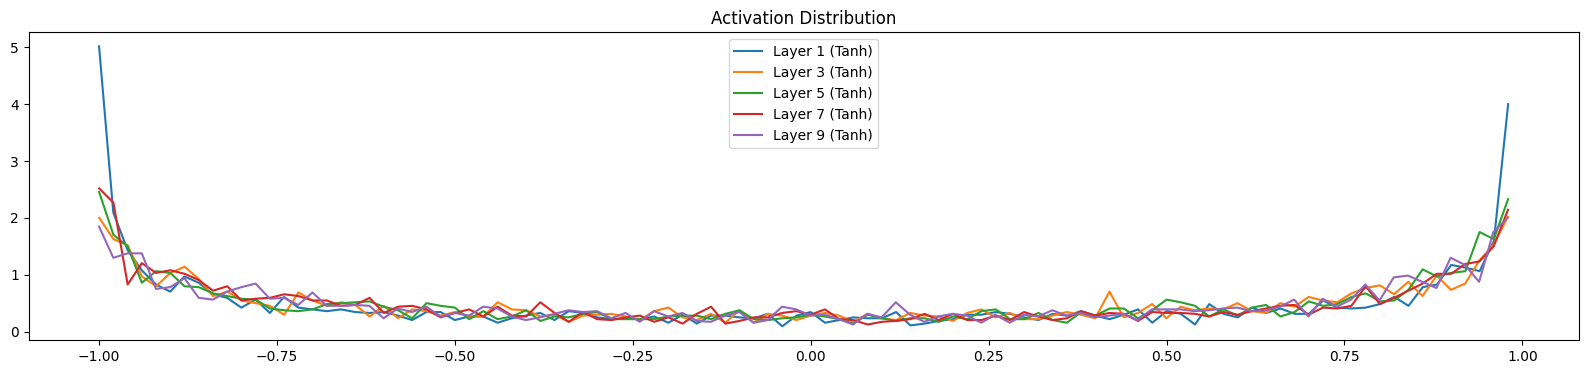

In [76]:
# Visualize histograms (forward pass activations) for the Tanh layers
# We can see how many tensor values take on which x-axis values
plt.figure(figsize=(20, 4)) # Width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # Note: Excluding the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'Layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('Activation Distribution')

layer 1 (      Tanh): mean +0.000024, std 3.353992e-03
layer 3 (      Tanh): mean +0.000012, std 3.157345e-03
layer 5 (      Tanh): mean -0.000004, std 2.925863e-03
layer 7 (      Tanh): mean +0.000036, std 2.715700e-03
layer 9 (      Tanh): mean +0.000020, std 2.308167e-03


Text(0.5, 1.0, 'Gradient Distribution')

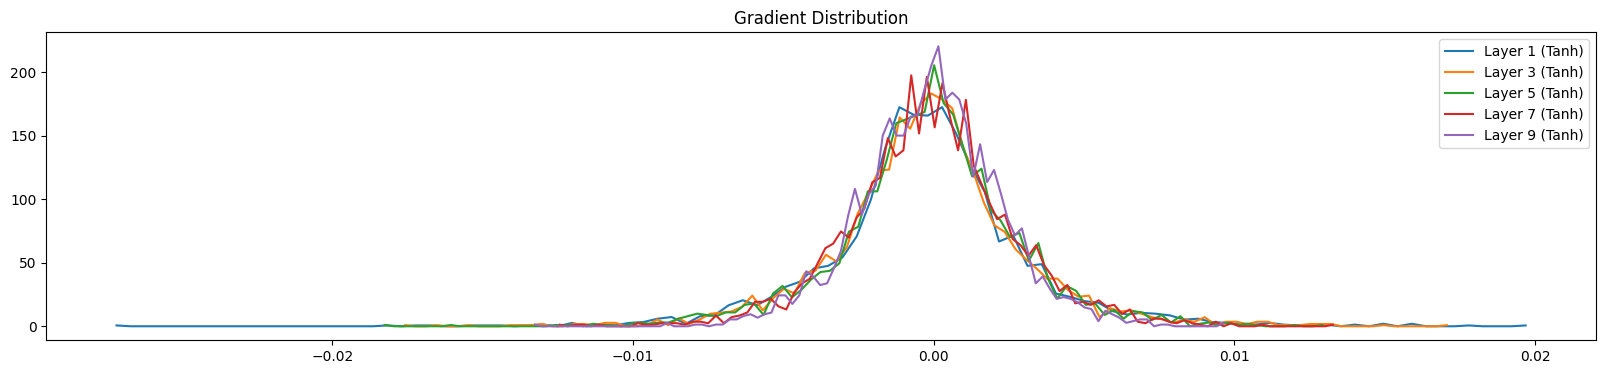

In [77]:
# Visualize Gradient Histogram (this graph looks good)
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'Layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('Gradient Distribution')

weight   (27, 10) | mean +0.000980 | std 1.189171e-02 | grad:data ratio 1.189149e-02
weight  (30, 100) | mean +0.000118 | std 1.005291e-02 | grad:data ratio 3.214557e-02
weight (100, 100) | mean +0.000033 | std 7.821213e-03 | grad:data ratio 4.653363e-02
weight (100, 100) | mean -0.000107 | std 6.655623e-03 | grad:data ratio 3.925852e-02
weight (100, 100) | mean -0.000017 | std 6.086042e-03 | grad:data ratio 3.605769e-02
weight (100, 100) | mean -0.000077 | std 5.075620e-03 | grad:data ratio 3.015269e-02
weight  (100, 27) | mean -0.000000 | std 2.056585e-02 | grad:data ratio 2.909911e-01


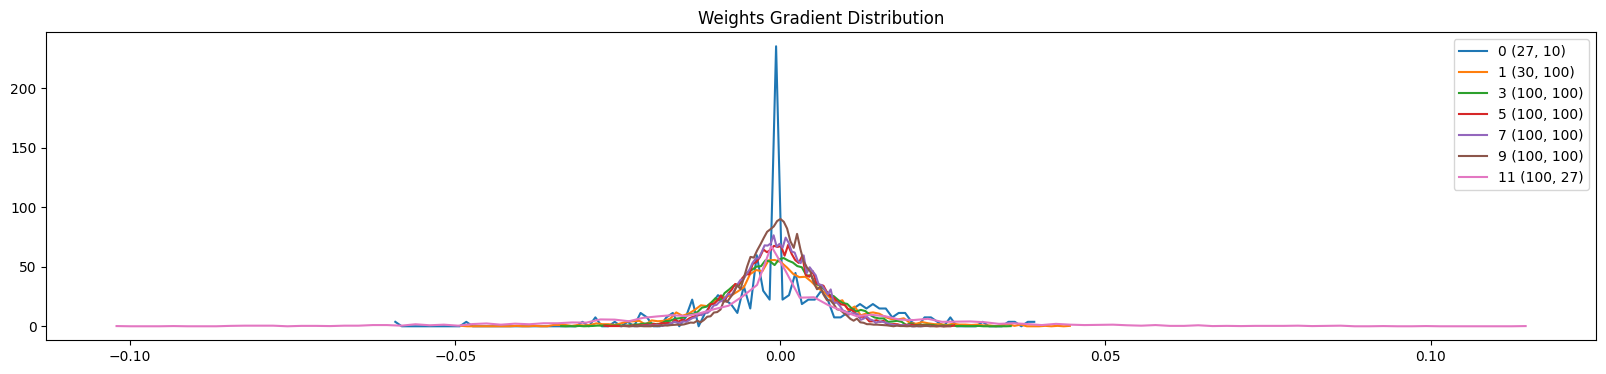

In [78]:
# Visualize histogram of weights of linear Layers (not biases, gammas or betas)
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('Weights Gradient Distribution');

We now additionally show the gradient data value ratio here.<br>
If the ratio is too large, we have a problem. Then something is wrong with the data and/or the characteristics of the neurons in general.<br>
But this is not the case here.

(Output is not counted in the ratio evaluation, it is ignored)

### Activation Distribution and Gradient Distribution for MLP with Tanh and Too Small Gain

Ok, for the sake of completeness, let's take a look at another graph that can help with the performance and structure analysis of such models: The Update-to-Data-Ratio. So this is not the pure intensity of change for a value, as with the gradient, but the actual data value by which the neurons are adjusted.

For this we have extended the code above with the Update-to-Data-Ratio variable `ud`.

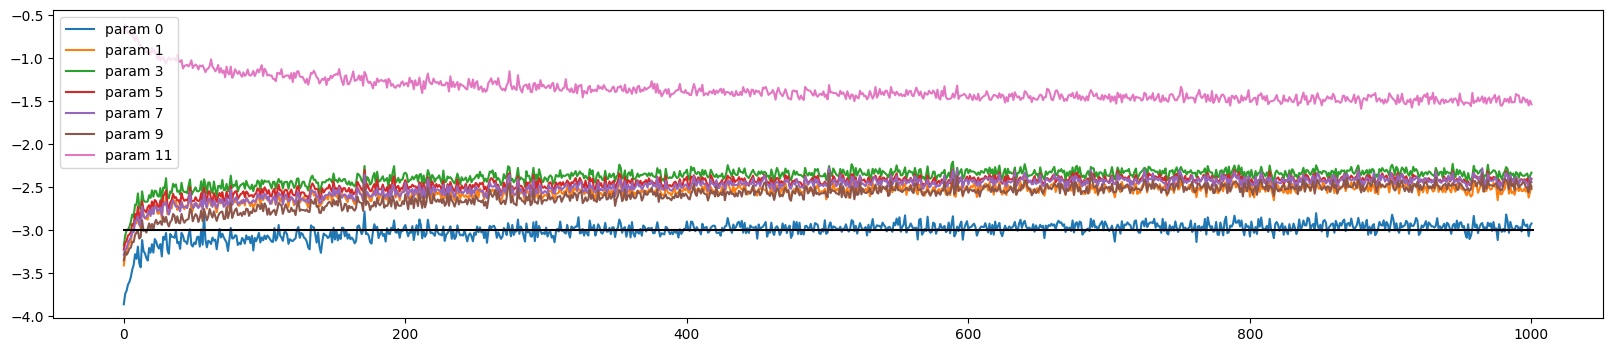

In [79]:
# Update to Data Ratio Histogram (below is what it looks like ideally)
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

We plot the parameters. With the black line we give the ideal course, as we would expect the parameter course (somewhere around $-3$ the logarithm should flatten out). The output layer is once again an outlier, because we had scaled it down by a factor of `0.1` during initialization to make this layer a little more flexible/less "confidently wrong". This artificially reduced the weights, which is why layer $11$ deviates like this.

> If the logarithm of a layer flattens around $-3$, this layer learns well.<br>
> If the parameters would settle significantly below $-3$, the **learning rate would be too low**.

**Now let's address the elephant in the room:**<br>
**The Forward-Pass Activation Distribution implies that activations tend towards the Tanh value boundaries and thus slow down the learning effect.**<br>**So we need Batch-Normalization:**

### Activation Distribution and Gradient Distribution for MLP with Tanh and Batch-Norm and Turned Off Gain

In [80]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd), generator=g)

layers = [
  Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size), BatchNorm1d(vocab_size), 
]

with torch.no_grad():
  # Last layer: make less confident
  layers[-1].gamma *= 0.1 # As last layer is a Batch-Normalization
  # All other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0

# Embedding matrix + all parameters in all layers = total involved parameters
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total

# These parameters will be affected by backpropagation
for p in parameters:
  p.requires_grad = True

47551


In [81]:
# Same optimization as last time
max_steps = 200000 
batch_size = 32    
lossi = []         # Keeping track of loss
ud = []            # Keeping track of Update-to-Data ratio

for i in range(max_steps):
  # Minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # Forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # Backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # Update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # Tracking the stats
  if i % 10000 == 0: # Print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2870


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.78%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.56%
layer 8 (      Tanh): mean -0.00, std 0.65, saturated: 2.25%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.69%
layer 14 (      Tanh): mean +0.00, std 0.65, saturated: 1.88%


Text(0.5, 1.0, 'activation distribution')

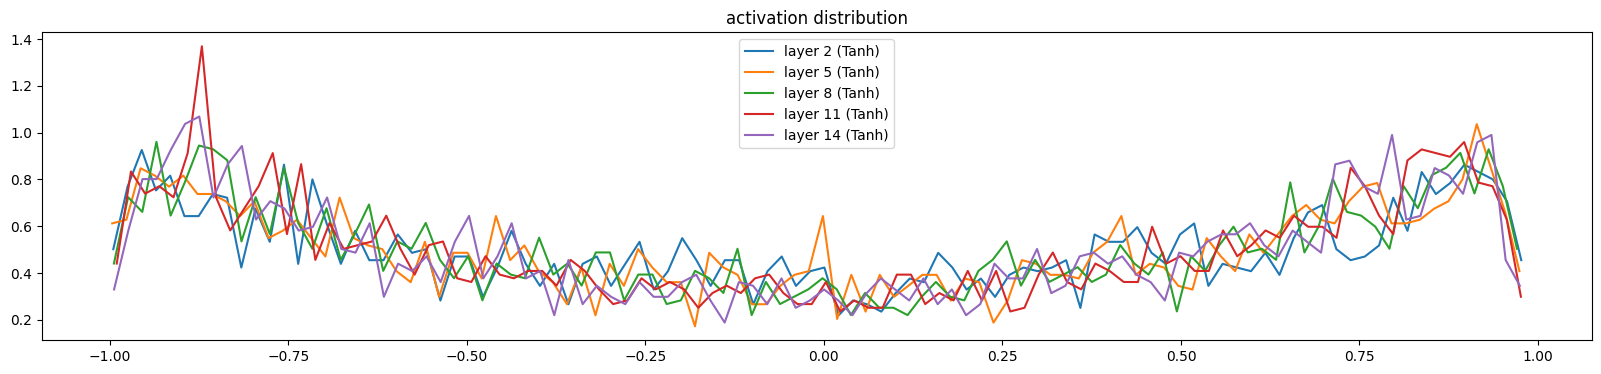

In [82]:
# Visualize histograms (forward pass activations) for the Tanh layers
# This is the ideal graph, very homogeneous
plt.figure(figsize=(20, 4)) # Width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # Note: Excluding the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 2.640702e-03
layer 5 (      Tanh): mean -0.000000, std 2.245584e-03
layer 8 (      Tanh): mean +0.000000, std 2.045742e-03
layer 11 (      Tanh): mean -0.000000, std 1.983134e-03
layer 14 (      Tanh): mean -0.000000, std 1.952382e-03


Text(0.5, 1.0, 'gradient distribution')

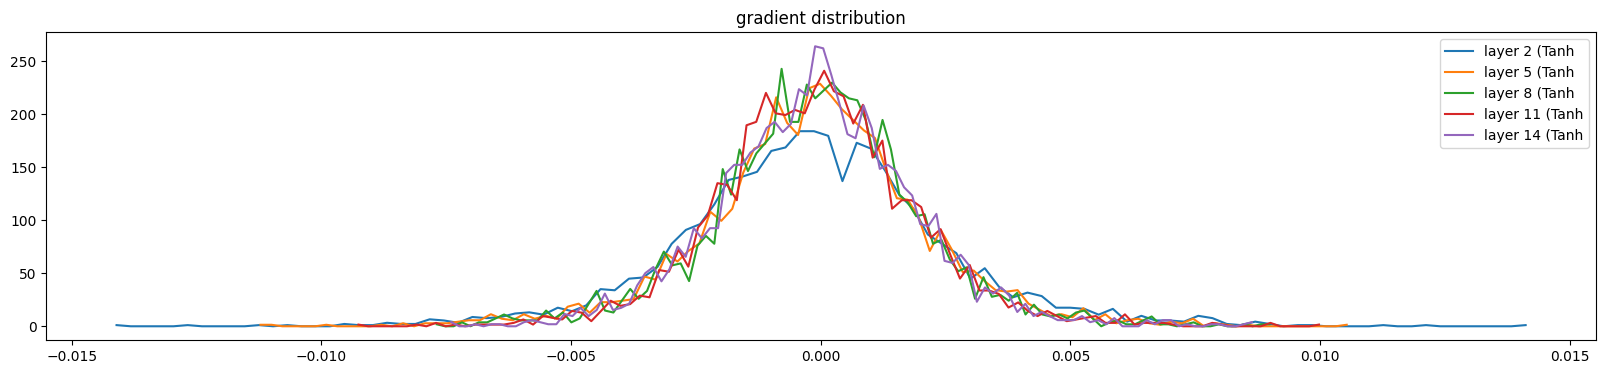

In [83]:
# Visualize Gradient Histogram (this graph looks good)
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000000 | std 8.020534e-03 | grad:data ratio 8.012630e-03
weight  (30, 100) | mean +0.000246 | std 9.241073e-03 | grad:data ratio 4.881089e-02
weight (100, 100) | mean +0.000113 | std 7.132876e-03 | grad:data ratio 6.964616e-02
weight (100, 100) | mean -0.000086 | std 6.234303e-03 | grad:data ratio 6.073739e-02
weight (100, 100) | mean +0.000052 | std 5.742185e-03 | grad:data ratio 5.631480e-02
weight (100, 100) | mean +0.000032 | std 5.672204e-03 | grad:data ratio 5.570124e-02
weight  (100, 27) | mean -0.000082 | std 1.209415e-02 | grad:data ratio 1.160105e-01


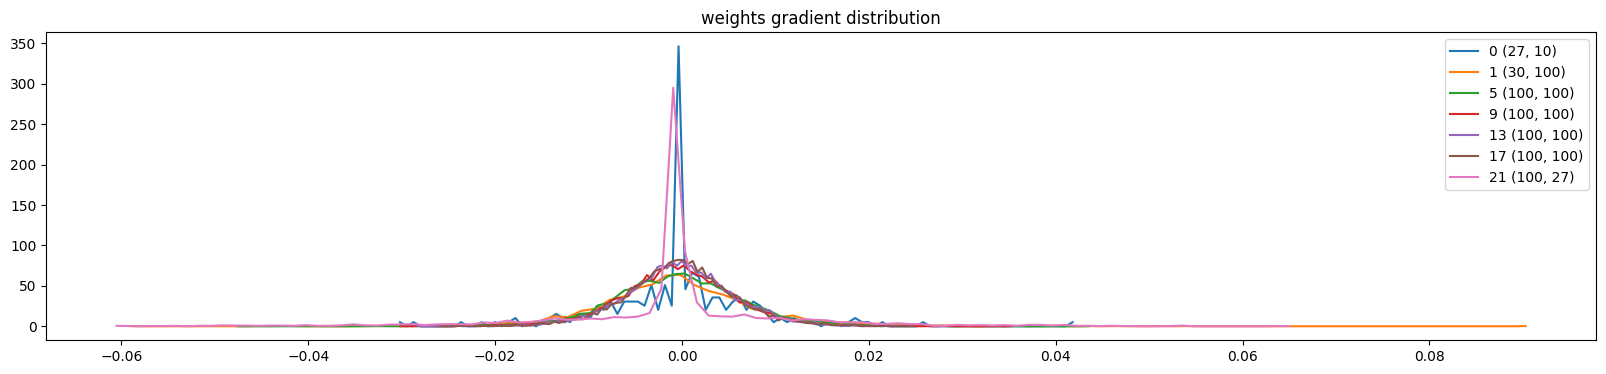

In [84]:
# Visualize histogram of weights of linear Layers (not biases, gammas or betas)
# Ideal graph
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

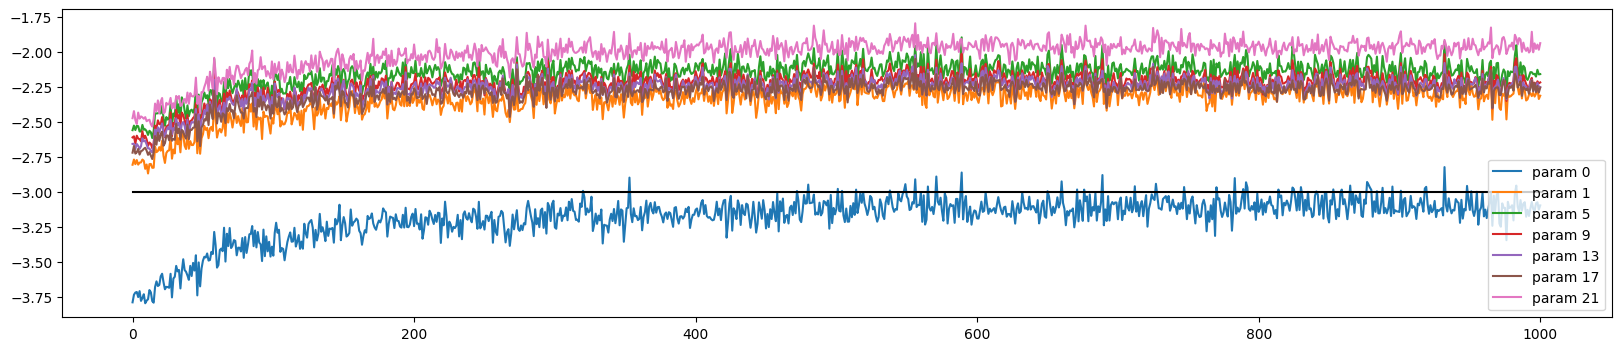

In [85]:
# Update to Data Ratio Histogram (below is what it looks like ideally)
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

We are much more robust against the gain to a certain degree.<br>
Nevertheless, it still has an effect on the data ratio histogram.<br>
So you still have to find a gain that is not too big and not too small, albeit in a targeted way.<br>
(In our case we just have `1`, i.e. no effect. That fits.)

## Bonus Content (Not Covered in Lecture)

In [1]:
# BatchNorm forward pass as a widget

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import torch

def normshow(x0):
  
  g = torch.Generator().manual_seed(2147483647+1)
  x = torch.randn(5, generator=g) * 5
  x[0] = x0 # override the 0th example with the slider
  mu = x.mean()
  sig = x.std()
  y = (x - mu)/sig

  plt.figure(figsize=(10, 5))
  # plot 0
  plt.plot([-6,6], [0,0], 'k')
  # plot the mean and std
  xx = np.linspace(-6, 6, 100)
  plt.plot(xx, stats.norm.pdf(xx, mu, sig), 'b')
  xx = np.linspace(-6, 6, 100)
  plt.plot(xx, stats.norm.pdf(xx, 0, 1), 'r')
  # plot little lines connecting input and output
  for i in range(len(x)):
    plt.plot([x[i],y[i]], [1, 0], 'k', alpha=0.2)
  # plot the input and output values
  plt.scatter(x.data, torch.ones_like(x).data, c='b', s=100)
  plt.scatter(y.data, torch.zeros_like(y).data, c='r', s=100)
  plt.xlim(-6, 6)
  # title
  plt.title('input mu %.2f std %.2f' % (mu, sig))

interact(normshow, x0=(-30,30,0.5));

interactive(children=(FloatSlider(value=0.0, description='x0', max=30.0, min=-30.0, step=0.5), Output()), _dom…

In [87]:
# Linear: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

a = torch.randn((1000,1), requires_grad=True, generator=g)          # a.grad = b.T @ c.grad
b = torch.randn((1000,1000), requires_grad=True, generator=g)       # b.grad = c.grad @ a.T
c = b @ a
loss = torch.randn(1000, generator=g) @ c
a.retain_grad()
b.retain_grad()
c.retain_grad()
loss.backward()
print('a std:', a.std().item())
print('b std:', b.std().item())
print('c std:', c.std().item())
print('-----')
print('c grad std:', c.grad.std().item())
print('a grad std:', a.grad.std().item())
print('b grad std:', b.grad.std().item())

a std: 0.9875972270965576
b std: 1.0006722211837769
c std: 31.01241683959961
-----
c grad std: 0.9782556295394897
a grad std: 30.8818302154541
b grad std: 0.9666601419448853


In [88]:
# Linear + BatchNorm: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

n = 1000
# linear layer ---
inp = torch.randn(n, requires_grad=True, generator=g)
w = torch.randn((n, n), requires_grad=True, generator=g) # / n**0.5
x = w @ inp
# bn layer ---
xmean = x.mean()
xvar = x.var()
out = (x - xmean) / torch.sqrt(xvar + 1e-5)
# ----
loss = out @ torch.randn(n, generator=g)
inp.retain_grad()
x.retain_grad()
w.retain_grad()
out.retain_grad()
loss.backward()

print('inp std: ', inp.std().item())
print('w std: ', w.std().item())
print('x std: ', x.std().item())
print('out std: ', out.std().item())
print('------')
print('out grad std: ', out.grad.std().item())
print('x grad std: ', x.grad.std().item())
print('w grad std: ', w.grad.std().item())
print('inp grad std: ', inp.grad.std().item())

inp std:  0.9875972270965576
w std:  1.0006722211837769
x std:  31.01241683959961
out std:  1.0
------
out grad std:  0.9782556295394897
x grad std:  0.031543977558612823
w grad std:  0.031169468536973
inp grad std:  0.9953052997589111
